In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from itertools import combinations

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix , roc_auc_score, precision_score, recall_score
import lightgbm as lgb

from atm_info import *

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Learning DOS, unary, binary and ternary database 

In [2]:
# Les configurations unaires + binaires + ternaires 
database = pd.read_excel("./Data/DATA_TOT_UBT.xlsx")
database = database.query("Enthalpie<300") 
database

,Unnamed: 0,DIR,prototype,nT,X1,X2,X3,X4,a,b,...,ElecN4,Eval1,Eval2,Eval3,Eval4,EA,EB,EC,ED,eVal_tot
0,0,10-Mo,phase-W,1,Mo,Mo,Mo,Mo,2.728527,2.728527,...,0.131267,6,6,6,6,-10.94954,-10.94954,-10.94954,-10.94954,24
1,1,11-Nb_sv,phase-W,1,Nb,Nb,Nb,Nb,2.865372,2.865372,...,0.128078,5,5,5,5,-10.21612,-10.21612,-10.21612,-10.21612,20
2,2,12-Ni,phase-W,1,Ni,Ni,Ni,Ni,2.423936,2.423936,...,0.147207,10,10,10,10,-5.46695,-5.46695,-5.46695,-5.46695,40
3,3,13-P,phase-W,1,P,P,P,P,2.639540,2.639540,...,0.206931,5,5,5,5,-5.40967,-5.40967,-5.40967,-5.40967,20
4,4,14-Sb,phase-W,1,Sb,Sb,Sb,Sb,3.280747,3.280747,...,0.191877,5,5,5,5,-4.13565,-4.13565,-4.13565,-4.13565,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76723,34051,74-Cu-Zn-Sn2,Heusler-Inverse,4,Sn,Cu,Zn,Sn,4.946313,4.946313,...,0.178052,4,11,12,4,-3.83392,-3.72720,-1.10764,-3.83392,31
76724,34052,75-Cu-Zn-Sb2,Heusler-Inverse,4,Sb,Cu,Zn,Sb,4.977904,4.977904,...,0.191877,5,11,12,5,-4.13565,-3.72720,-1.10764,-4.13565,33
76725,34053,7-Mn-Co-Si2,Heusler-Inverse,4,Si,Mn,Co,Si,4.011498,4.011498,...,0.178503,4,7,9,4,-5.17948,-8.97821,-7.03500,-5.17948,24
76726,34054,8-Mn-Co-P2,Heusler-Inverse,4,P,Mn,Co,P,4.034537,4.034537,...,0.206931,5,7,9,5,-5.40967,-8.97821,-7.03500,-5.40967,26


In [3]:
# Database analysis
metal = len(database.loc[database['eta']!='semicond'])
semicond = len(database.loc[database['eta']=='semicond'])
print('metal:', metal, 'semicond:', semicond)

metal: 75841 semicond: 773


In [4]:
# Randomly split the database into 90% trains and 10% tests
Train, Test  = train_test_split(database, test_size=0.10, random_state=46, shuffle = True)

In [5]:
# Construction of X 
ohe = OneHotEncoder(sparse=False)
X_ohe = ohe.fit_transform(Train[['X1','X2','X3','X4']])
EVal_tot = ((Train[['eVal_tot']])-database['eVal_tot'].min())/(database['eVal_tot'].max()-database['eVal_tot'].min()) #normaliser par MinMaxScaler
X=np.append(X_ohe, EVal_tot, axis=1)

# Construction of y
y = Train['eta']

print('X:', X.shape, 'y:', y.shape)

# Database analysis 
metal = len(Train.loc[Train['eta']!='semicond'])
semicond = len(Train.loc[Train['eta']=='semicond'])
print('metal:', metal, 'semicond:', semicond)

X: (68952, 97) y: (68952,)
metal: 68253 semicond: 699


In [6]:
%%time

model = lgb.LGBMClassifier(boosting_type='dart', max_depth=4, learning_rate=0.1, n_estimators=200, 
                                        subsample=0.8, colsample_bytree=0.8, scale_pos_weight = metal/(semicond*0.25), 
                                        random_state=0) 
model.fit(X,y)

Wall time: 712 ms


LGBMClassifier(boosting_type='dart', colsample_bytree=0.8, max_depth=4,
               n_estimators=200, random_state=0,
               scale_pos_weight=390.57510729613733, subsample=0.8)

In [7]:
# Confusion matrix
#   metal_pred_metal     metal_pred_semicond
#   semicond_pred_metal  semicond_pred_semicond

y_train_predic = model.predict(X)

print("Accuracy Train :", accuracy_score(y, y_train_predic))
print("Matrix Train : \n", confusion_matrix(y,y_train_predic))
print("Precision Train : ", precision_score(y, y_train_predic, average=None )) #'micro'))
print("Recall Train : ", recall_score(y, y_train_predic, average=None))

tn, fp, fn, tp = confusion_matrix(y, y_train_predic).ravel()
tpr = tp/(tp+fn) 
fpr = fp/(fp+tn)
G_mean = (tpr*(1-fpr))**0.5
tn, fp, fn, tp, G_mean
print("tn:",tn)
print("fp:",fp)
print("fn:",fn)
print("tp:",tp)
print("tpr:",tpr)
print("fpr:",fpr)
print("G_mean:",G_mean)

Accuracy Train : 0.7928994082840237
Matrix Train : 
 [[53973 14280]
 [    0   699]]
Precision Train :  [1.         0.04666533]
Recall Train :  [0.79077843 1.        ]
tn: 53973
fp: 14280
fn: 0
tp: 699
tpr: 1.0
fpr: 0.20922157267812405
G_mean: 0.8892572334942662


In [8]:
def return_valen_tot_normed(A, B, C, D):
    element = return_valen_el(A)+return_valen_el(B)+return_valen_el(C)+return_valen_el(D)
    return pd.DataFrame([(element-database['eVal_tot'].min())/(database['eVal_tot'].max()-database['eVal_tot'].min())])
 
def return_calcul(A,B,C,D):
    config=X[(X['X1'] == A) & (X['X2'] == B) & (X['X3'] == C) & (X['X4'] == D)]
    return y[config.index[0]]

def return_predic(A,B,C,D, ohe, model):
    A_Pred=pd.DataFrame([[A,B,C,D]], columns = ['X1','X2','X3','X4'])
    X_pred = np.append(ohe.transform(A_Pred), return_valen_tot_normed(A,B,C,D), axis=1) 
    pred= model.predict(X_pred)[0]
    if pred == 0 : 
        pred = 'metal'
    if pred == 1 : 
        pred = 'semicond'
    return pred

In [9]:
# Semicond

configurations=[
                # https://cyberleninka.org/article/n/108844.pdf CoZrMnSi, CoYFeSi, CoZrFeSi,  CoYMnSi, 
                ["Co","Mn","Zr","Si"], ["Co","Zr","Mn","Si"], ["Co","Si","Mn","Zr"], #semicond
                ["Co","Fe","Y","Si"], ["Co","Y","Fe","Si"], ["Co","Si","Fe","Y"],    #zerogap 
    
                # https://ieeexplore.ieee.org/document/9481140 CoFeCrAl
                ["Co","Fe","Cr","Al"], ["Co","Cr","Fe","Al"], ["Co","Al","Fe","Cr"], 
                # potential spin gapless semiconductor
               
                # https://www.academia.edu/Documents/in/Spin_Gapless_Semiconductor CoFeMnSi  
                ["Co","Mn","Fe","Si"], ["Co","Fe","Mn","Si"], ["Co","Si","Mn","Fe"],  # spin-gapless ?  
                ] 

for conf in configurations:
    pre=return_predic(conf[0],conf[1],conf[2],conf[3], ohe, model)
    print(conf, ' predicted at ', pre, 'kJ/mol')

['Co', 'Mn', 'Zr', 'Si']  predicted at  semicond kJ/mol
['Co', 'Zr', 'Mn', 'Si']  predicted at  semicond kJ/mol
['Co', 'Si', 'Mn', 'Zr']  predicted at  semicond kJ/mol
['Co', 'Fe', 'Y', 'Si']  predicted at  semicond kJ/mol
['Co', 'Y', 'Fe', 'Si']  predicted at  semicond kJ/mol
['Co', 'Si', 'Fe', 'Y']  predicted at  semicond kJ/mol
['Co', 'Fe', 'Cr', 'Al']  predicted at  metal kJ/mol
['Co', 'Cr', 'Fe', 'Al']  predicted at  metal kJ/mol
['Co', 'Al', 'Fe', 'Cr']  predicted at  metal kJ/mol
['Co', 'Mn', 'Fe', 'Si']  predicted at  semicond kJ/mol
['Co', 'Fe', 'Mn', 'Si']  predicted at  semicond kJ/mol
['Co', 'Si', 'Mn', 'Fe']  predicted at  semicond kJ/mol


In [10]:
%%time
Prediction = Test.copy()
Prediction = Prediction[["X1","X2","X3","X4","eta"]]
Prediction['Pred_eta'] = Prediction.apply(lambda x: return_predic(x.X1, x.X2, x.X3, x.X4, ohe, model), axis=1)
Prediction

Wall time: 11.8 s


,X1,X2,X3,X4,eta,Pred_eta
24990,P,Cr,P,Y,metal,metal
75918,Mo,Co,Fe,Mo,metal,metal
21100,Si,Fe,Zn,Fe,metal,metal
73522,La,V,Ti,V,metal,metal
23948,Zr,Sn,Sn,Ni,metal,metal
...,...,...,...,...,...,...
16678,Sr,Fe,Sr,Sn,metal,metal
59078,Mo,V,V,W,metal,metal
75079,Zn,Co,Mn,Zn,metal,semicond
5927,Mn,Mn,Sb,Sr,metal,metal


In [11]:
y_test_predic = Prediction['Pred_eta']
y_test = Prediction['eta']

print("Accuracy Test : ", accuracy_score(y_test, y_test_predic))
print("Matrix Test : \n", confusion_matrix(y_test,y_test_predic))
print("Precision Test : ", precision_score(y_test, y_test_predic, average=None )) 
print("Recall Test : ", recall_score(y_test, y_test_predic, average=None))

tn, fp, fn, tp = confusion_matrix(Prediction['eta'],Prediction['Pred_eta']).ravel()
tpr = tp/(tp+fn) 
fpr = fp/(fp+tn)
G_mean = (tpr*(1-fpr))**0.5

#tn, fp, fn, tp, G_mean
print("tn:",tn)
print("fp:",fp)
print("fn:",fn)
print("tp:",tp)

print("tpr:",tpr)
print("fpr:",fpr)
print("G_mean:",G_mean)

Accuracy Test :  0.7876533542156094
Matrix Test : 
 [[5961 1627]
 [   0   74]]
Precision Test :  [1.         0.04350382]
Recall Test :  [0.7855825 1.       ]
tn: 5961
fp: 1627
fn: 0
tp: 74
tpr: 1.0
fpr: 0.21441750131787032
G_mean: 0.8863309193986915


## Cross-Validation

In [12]:
def Initialisation(database) :    
    ohe = OneHotEncoder(sparse=False)
    X_ohe = ohe.fit_transform(database[['X1','X2','X3','X4']])
    EVal_tot = ((database[['eVal_tot']])-database['eVal_tot'].min())/(database['eVal_tot'].max()-database['eVal_tot'].min()) #normaliser par MinMaxScaler 
    return np.append(X_ohe, EVal_tot, axis=1)

In [13]:
%%time

# Cross-validation 
database_cv = shuffle(database.copy(), random_state=12)
database_cv=database_cv.sample(random_state=9, frac=1).reset_index(drop=True)

n_split=10
separa = list(range(0, len(database_cv), int(len(database_cv)/n_split)))
separa.append(len(database_cv))
print("list",separa)

i = 0
Liste = pd.DataFrame([])
for sep in separa : 
    i= i+1
    if i<=(n_split):  
        print('---------------------------------------------------------------')
        print("CV n°",i)
        print("Index des données test : ",sep," - ", separa[i])
        Train = pd.concat([database_cv[0:sep], database_cv[separa[i]:len(database_cv)]])
        Test = database_cv[sep:separa[i]]

        # Entrainement : 
        X = Train[['X1','X2','X3','X4']]
        y = Train['eta']
        X_cv = Initialisation(Train)
        metal = len(Train.loc[Train['eta']!='semicond'])
        semicond = len(Train.loc[Train['eta']=='semicond'])
        print('metal:', metal, 'semicond:', semicond)
        
        if i <= n_split : 
            model = lgb.LGBMClassifier(boosting_type='dart', max_depth=4, learning_rate=0.1,
                                       n_estimators=200, subsample=0.8, colsample_bytree=0.8, 
                                       scale_pos_weight = metal/(semicond*0.25), random_state=0) 
            model.fit(X_cv,y)
            
            y_train_predic = model.predict(X_cv)
            CM = confusion_matrix(y, y_train_predic)
            Precision = precision_score(y, y_train_predic, average=None )
            Recall = recall_score(y, y_train_predic, average=None)
            
            print("Matrix Train : \n", CM)
            print("Precision Train : ", Precision) #'micro'))
            print("Recall Train : ", Recall)
            
            tn_train, fp_train, fn_train, tp_train = confusion_matrix(y, y_train_predic).ravel()
            tpr_train = tp_train/(tp_train+fn_train) 
            fpr_train = fp_train/(fp_train+tn_train)
            G_mean_train = (tpr_train*(1-fpr_train))**0.5
            
            # Evaluation :  
            Predict = Test.copy()
            Predict['Pred_eta'] = Predict.apply(lambda x: return_predic(x.X1, x.X2, x.X3, x.X4, ohe, model), axis=1)
            y_test_predic = Predict['Pred_eta']
            y_test = Predict['eta']
            
            print("Matrix Test : \n", confusion_matrix(y_test,y_test_predic))
            print("Precision Test : ", precision_score(y_test, y_test_predic, average=None )) #'micro'))
            print("Recall Test : ", recall_score(y_test, y_test_predic, average=None))

            tn_test, fp_test, fn_test, tp_test = confusion_matrix(Predict['eta'],Predict['Pred_eta']).ravel()
            tpr_test = tp_test/(tp_test+fn_test) 
            fpr_test = fp_test/(fp_test+tn_test)
            G_mean_test = (tpr_test*(1-fpr_test))**0.5  
            
            Result = pd.DataFrame({'tn_train':[tn_train], 'fp_train':[fp_train], 
                                     'fn_train' : [fn_train], 'tp_train' : [tp_train], 
                                      'G_mean_train' : [G_mean_train], 'tn_test' : [tn_test], 
                                      'fp_test' :  [fp_test], 'fn_test' :  [fn_test],
                                      'tp_test' : [tp_test], 'G_mean_test'  : [G_mean_test] , 
                                      'tpr_test': [tpr_test], 'fpr_test':[fpr_test]})
            Liste = pd.concat([Liste, Result])
            #print(Liste)
            

list [0, 7661, 15322, 22983, 30644, 38305, 45966, 53627, 61288, 68949, 76610, 76614]
---------------------------------------------------------------
CV n° 1
Index des données test :  0  -  7661
metal: 68249 semicond: 704
Matrix Train : 
 [[54116 14133]
 [    0   704]]
Precision Train :  [1.         0.04744895]
Recall Train :  [0.79292004 1.        ]
Matrix Test : 
 [[6020 1572]
 [   2   67]]
Precision Test :  [0.99966788 0.04087858]
Recall Test :  [0.79293994 0.97101449]
---------------------------------------------------------------
CV n° 2
Index des données test :  7661  -  15322
metal: 68259 semicond: 694
Matrix Train : 
 [[53818 14441]
 [    1   693]]
Precision Train :  [0.99998142 0.04579093]
Recall Train :  [0.78843815 0.99855908]
Matrix Test : 
 [[5969 1613]
 [   0   79]]
Precision Test :  [1.         0.04669031]
Recall Test :  [0.7872593 1.       ]
---------------------------------------------------------------
CV n° 3
Index des données test :  15322  -  22983
metal: 68248 semi

In [14]:
Liste

,tn_train,fp_train,fn_train,tp_train,G_mean_train,tn_test,fp_test,fn_test,tp_test,G_mean_test,tpr_test,fpr_test
0,54116,14133,0,704,0.890461,6020,1572,2,67,0.877471,0.971014,0.207060
0,53818,14441,1,693,0.887300,5969,1613,0,79,0.887276,1.000000,0.212741
0,54005,14243,0,705,0.889553,6002,1591,3,65,0.869248,0.955882,0.209535
0,54261,14011,2,679,0.890192,6045,1524,0,92,0.893674,1.000000,0.201348
0,53804,14444,0,705,0.887896,5990,1603,28,40,0.681212,0.588235,0.211116
0,53917,14346,0,690,0.888731,5892,1686,1,82,0.876440,0.987952,0.222486
0,53940,14310,0,703,0.889005,5984,1607,0,70,0.887864,1.000000,0.211698
0,54726,13545,1,681,0.894664,6091,1479,4,87,0.877072,0.956044,0.195376
0,53982,14268,0,703,0.889351,6029,1562,0,70,0.891196,1.000000,0.205770
0,54031,14232,0,690,0.889670,5966,1612,1,82,0.881926,0.987952,0.212721


In [15]:
# The average value of the G-mean by cross-validation 
Liste['G_mean_test'].mean()

0.8623378156900934

## Quaternary prediction

### 1. Prediction on 1000 random quaternary combinations (24 000 configurations), unary, binary and ternary bases

In [16]:
%%time

# Construction of X 
ohe = OneHotEncoder(sparse=False)
X_ohe = ohe.fit_transform(database[['X1','X2','X3','X4']])
EVal_tot = ((database[['eVal_tot']])-database['eVal_tot'].min())/(database['eVal_tot'].max()-database['eVal_tot'].min()) #normaliser par MinMaxScaler
X=np.append(X_ohe, EVal_tot, axis=1)

# Construction of y
y = database['eta']

print('X:', X.shape, 'y:', y.shape)

# Analyse de la base de données 
metal = len(database.loc[database['eta']!='semicond'])
semicond = len(database.loc[database['eta']=='semicond'])
print('metal:', metal, 'semicond:', semicond)

# Apprentissage
model = lgb.LGBMClassifier(boosting_type='dart', max_depth=4, learning_rate=0.1, 
                           n_estimators=200, subsample=0.8, colsample_bytree=0.8, 
                           scale_pos_weight = metal/(semicond*0.25), random_state=0) 
model.fit(X,y)

# Evaluation du Train 
y_train_predic = model.predict(X)
print("Accuracy Train :", accuracy_score(y, y_train_predic))
print("Matrix Train : \n", confusion_matrix(y,y_train_predic))
print("Precision Train : ", precision_score(y, y_train_predic, average=None )) #'micro'))
print("Recall Train : ", recall_score(y, y_train_predic, average=None))

tn, fp, fn, tp = confusion_matrix(y, y_train_predic).ravel()
tpr = tp/(tp+fn) 
fpr = fp/(fp+tn)
G_mean = (tpr*(1-fpr))**0.5
tn, fp, fn, tp, G_mean
print("tn:",tn)
print("fp:",fp)
print("fn:",fn)
print("tp:",tp)
print("tpr:",tpr)
print("fpr:",fpr)
print("G_mean:",G_mean)

X: (76614, 97) y: (76614,)
metal: 75841 semicond: 773
Accuracy Train : 0.7920745555642572
Matrix Train : 
 [[59911 15930]
 [    0   773]]
Precision Train :  [1.         0.04627911]
Recall Train :  [0.7899553 1.       ]
tn: 59911
fp: 15930
fn: 0
tp: 773
tpr: 1.0
fpr: 0.21004469877770598
G_mean: 0.8887942963488762
Wall time: 2.11 s


In [4]:
# Prediction of 24,000 quaternary configurations 
Quatern = pd.read_excel("./Data/Quaternaires_24000_DFT.xlsx")
Quatern

,Unnamed: 0,DIR,prototype,A,B,C,D,nA,nB,nC,...,dosf,dosfat,eta,bu,bd,abd,X1,X2,X3,X4
0,0,1000-Ta-W-Fe-Co,Heusler_Quaternaires_C1,Ta,W,Fe,Co,1,1,1,...,3.950862,0.987715,metal,3.824956,-0.125906,0.125906,Ta,W,Fe,Co
1,1,100-Ti-Cr-W-Sn,Heusler_Quaternaires_C1,Ti,Cr,W,Sn,1,1,1,...,9.848608,2.462152,metal,4.919480,-4.929128,4.929128,Ti,Cr,W,Sn
2,2,101-Zr_sv-Cr-Zn-Al,Heusler_Quaternaires_C1,Zr,Cr,Zn,Al,1,1,1,...,1.189263,0.297316,metal,0.365224,-0.824039,0.824039,Zr,Cr,Zn,Al
3,3,102-Zr_sv-Cr-Sr_sv-Fe,Heusler_Quaternaires_C1,Zr,Cr,Sr,Fe,1,1,1,...,5.046228,1.261557,metal,3.678260,-1.367967,1.367967,Zr,Cr,Sr,Fe
4,4,103-W-Ba_sv-La-P,Heusler_Quaternaires_C1,W,Ba,La,P,1,1,1,...,4.560678,1.140170,metal,0.847548,-3.713130,3.713130,W,Ba,La,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,2995,997-Zr_sv-Zn-V-Mo,Heusler_Quaternaires_C3,Zr,Zn,V,Mo,1,1,1,...,5.233345,1.308336,metal,2.616672,-2.616672,2.616672,V,Mo,Zn,Zr
23996,2996,998-Cr-Sb-La-Cu,Heusler_Quaternaires_C3,Cr,Sb,La,Cu,1,1,1,...,9.437861,2.359465,metal,4.717477,-4.720384,4.720384,La,Cu,Sb,Cr
23997,2997,999-Mo-P-Sr_sv-Ni,Heusler_Quaternaires_C3,Mo,P,Sr,Ni,1,1,1,...,3.534955,0.883739,metal,1.259805,-2.275151,2.275151,Sr,Ni,P,Mo
23998,2998,99-V-Ni-Mo-W,Heusler_Quaternaires_C3,V,Ni,Mo,W,1,1,1,...,6.452037,1.613009,metal,3.226019,-3.226019,3.226019,Mo,W,Ni,V


In [18]:
%%time
Prediction = Quatern.copy()
Prediction = Prediction[["X1","X2","X3","X4","eta"]]
Prediction['Pred_eta'] = Prediction.apply(lambda x: return_predic(x.X1, x.X2, x.X3, x.X4, ohe, model), axis=1)
Prediction

Wall time: 38.8 s


,X1,X2,X3,X4,eta,Pred_eta
0,Ta,W,Fe,Co,metal,semicond
1,Ti,Cr,W,Sn,metal,semicond
2,Zr,Cr,Zn,Al,metal,metal
3,Zr,Cr,Sr,Fe,metal,semicond
4,W,Ba,La,P,metal,metal
...,...,...,...,...,...,...
23995,V,Mo,Zn,Zr,metal,metal
23996,La,Cu,Sb,Cr,metal,metal
23997,Sr,Ni,P,Mo,metal,metal
23998,Mo,W,Ni,V,metal,metal


In [19]:
y_test_predic = Prediction['Pred_eta']
y_test = Prediction['eta']

print("Accuracy Test : ", accuracy_score(y_test, y_test_predic))
print("Matrix Test : \n", confusion_matrix(y_test,y_test_predic))
print("Precision Test : ", precision_score(y_test, y_test_predic, average=None )) 
print("Recall Test : ", recall_score(y_test, y_test_predic, average=None))

tn, fp, fn, tp = confusion_matrix(Prediction['eta'],Prediction['Pred_eta']).ravel()
tpr = tp/(tp+fn) 
fpr = fp/(fp+tn)
G_mean = (tpr*(1-fpr))**0.5

#tn, fp, fn, tp, G_mean
print("tn:",tn)
print("fp:",fp)
print("fn:",fn)
print("tp:",tp)

print("tpr:",tpr)
print("fpr:",fpr)
print("G_mean:",G_mean)

Accuracy Test :  0.7722083333333334
Matrix Test : 
 [[18221  5459]
 [    8   312]]
Precision Test :  [0.99956114 0.05406342]
Recall Test :  [0.76946791 0.975     ]
tn: 18221
fp: 5459
fn: 8
tp: 312
tpr: 0.975
fpr: 0.2305320945945946
G_mean: 0.8661588813666176


### 2. Prediction of quaternaries using the unary, binary, ternary and quaternary database 

In [21]:
# Unary + binary + ternary configurations 
data_UBT = pd.read_excel("./Data/DATA_TOT_UBT.xlsx")

# Quaternary configurations 
data_Q = pd.read_excel("./Data/24000_configurations_quaternaires.xlsx")

# 1000 quaternary combinations  
combinaisons_q = pd.read_excel("./Data/3000_combinaisons_quaternaires.xlsx","DFT_Config1")

In [22]:
# Number of combinations to be taken into account and modified  
# Extract combinations : 
def Extract_combo(combinaisons_q_random) : 
    apprentissage_q = combinaisons_q_random.copy()
    apprentissage_q = apprentissage_q.iloc[apprentissage_q.index<250]  # Selectionner la quantité de quaternaire (max 999)
    apprentissage_q[['X1','X2','X3','X4']] = apprentissage_q[['A','B','C','D']]
    return apprentissage_q

In [23]:
# This function can be used to search for quaternary compounds in different configurations  
def recherche(data, A, B, C, D) : 
    X1 = 'X1' ; X2 = 'X2' ; X3 = 'X3' ; X4 = 'X4' ; 
    Compose = data.loc[((data[X1]==A)|(data[X2]==A))|((data[X3]==A)|(data[X4]==A))]
    Compose = Compose.loc[((Compose[X1]==B)|(Compose[X2]==B))|((Compose[X3]==B)|(Compose[X4]==B))]
    Compose = Compose.loc[((Compose[X1]==C)|(Compose[X2]==C))|((Compose[X3]==C)|(Compose[X4]==C))]
    Compose = Compose.loc[((Compose[X1]==D)|(Compose[X2]==D))|((Compose[X3]==D)|(Compose[X4]==D))]
    return Compose
#recherche(data_Q,'Zr','Zn','V','Mo')

# Extract configurations from combinations 
def Extract_conf(apprentissage_q, data_Q) : 
    termes = pd.DataFrame([])
    for i in apprentissage_q.index : 
        Ligne = apprentissage_q.iloc[i]
        A = Ligne['X1']; B = Ligne['X2'] ; C = Ligne['X3'] ; D = Ligne['X4']
        Config = recherche(data_Q, A, B, C, D)
        termes = pd.concat([termes, Config])
    return termes 

def Ajout_features(termes) : 
    termes2 = termes.copy()
    termes2['eVal_tot'] = termes2['elec-val-A']+termes2['elec-val-B']+termes2['elec-val-C']+termes2['elec-val-D']
    termes2 = termes2.rename({'Hf':'Enthalpie'},axis=1)
    termes2 = termes2[["X1","X2","X3","X4","eVal_tot","Enthalpie","eta"]]
    return termes2 

# All configurations except those in the learning base 
def Predict_Data(data_Q, termes) : 
    data_Q_re = data_Q.copy()
    data_Q_re = data_Q_re[["X1","X2","X3","X4","Hf","eta"]]
    db_apprend = termes[["X1","X2","X3","X4","Hf","eta"]]
    data_Q_re = pd.concat([data_Q_re, db_apprend])
    data_Q_re = data_Q_re.drop_duplicates(subset=None, keep=False, inplace=False, ignore_index=False)
    return data_Q_re

# Automatic learning 
def Apprentissage(database, data_Q_re) : 
    
    database = database.query("Enthalpie<300") 
    X = database[['X1','X2','X3','X4']]
    y = database['eta']
    y_dum=pd.get_dummies(y)
    y_dum=y_dum['semicond']
    print(database['eta'].value_counts())
    ohe = OneHotEncoder(sparse=False)
    X_ohe = ohe.fit_transform(X)
    EVal_tot = ((database[['eVal_tot']])-8)/(48-8) #normaliser à la main par MinMaxScaler 
    X_new_cv=np.append(X_ohe, EVal_tot, axis=1)
    X_new_cv.shape 

    model = lgb.LGBMClassifier(boosting_type='dart',  #goss, gbdt, dart
                                max_depth=6, # inf5
                                learning_rate=0.1,
                                n_estimators=200, #inf1000
                                subsample=0.8,  
                                colsample_bytree=0.8,
                                random_state = 0, 
                            
    scale_pos_weight = database['eta'].value_counts()[0]/(database['eta'].value_counts()[1]*0.15))
    
    model.fit(X_new_cv,y_dum)

    y_train_predic = model.predict(X_new_cv)
    CM = confusion_matrix(y_dum,y_train_predic)
    Precision = precision_score(y_dum, y_train_predic, average=None )
    Recall = recall_score(y_dum, y_train_predic, average=None)

    print("Matrix Train : \n", CM)
    print("Precision Train : ", Precision) #'micro'))
    print("Recall Train : ", Recall)

    tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_dum, y_train_predic).ravel()
    tpr_train = tp_train/(tp_train+fn_train) 
    fpr_train = fp_train/(fp_train+tn_train)
    G_mean_train = (tpr_train*(1-fpr_train))**0.5

    # Evaluation :  
    Predict = data_Q_re.copy()
    Predict['Pred_eta'] = Predict.apply(lambda x: return_predic(x.X1, x.X2, x.X3, x.X4, ohe, model), axis=1)
    y_test_predic = Predict['Pred_eta']
    y_test = Predict['eta']

    print("Matrix Test : \n", confusion_matrix(y_test,y_test_predic))
    print("Precision Test : ", precision_score(y_test, y_test_predic, average=None )) #'micro'))
    print("Recall Test : ", recall_score(y_test, y_test_predic, average=None))

    tn_test, fp_test, fn_test, tp_test = confusion_matrix(Predict['eta'],Predict['Pred_eta']).ravel()
    tpr_test = tp_test/(tp_test+fn_test) 
    fpr_test = fp_test/(fp_test+tn_test)
    G_mean_test = (tpr_test*(1-fpr_test))**0.5  

    Result = pd.DataFrame({'tn_train':[tn_train], 'fp_train':[fp_train], 
                             'fn_train' : [fn_train], 'tp_train' : [tp_train], 
                              'G_mean_train' : [G_mean_train], 
                           'tpr_train': [tpr_train], 'fpr_train':[fpr_train],
                           
                           'tn_test' : [tn_test], 'fp_test' :  [fp_test], 
                           'fn_test' :  [fn_test], 'tp_test' : [tp_test], 
                           'G_mean_test'  : [G_mean_test] , 
                            'tpr_test': [tpr_test], 'fpr_test':[fpr_test]})
    
    return Result    

In [24]:
data_UBT2 = data_UBT.copy()
data_UBT2 = data_UBT2[["X1","X2","X3","X4","eVal_tot","Enthalpie","eta"]]

# Build equivalent configurations and the basis for quaternary prediction 
combinaisons_q_random = combinaisons_q.copy()
combinaisons_q_random = shuffle(combinaisons_q_random, random_state=25) # Change the value of Random
# print('Exemple:', combinaisons_q_random.head(1))

apprentissage_q = Extract_combo(combinaisons_q_random)
#print(len(apprentissage_q))
termes = Extract_conf(apprentissage_q, data_Q)
termes2 = Ajout_features(termes)
#print(len(termes2))
data_Q_re = Predict_Data(data_Q, termes)
print('Exemple:', data_Q_re[["X1","X2","X3","X4"]].head(1))
#print(len(data_Q_re))

# DATA_TOT2 database and quaternaries assembly
database = pd.concat([data_UBT2,termes2])
database = database.reset_index()
Resultat = Apprentissage(database, data_Q_re) 

Exemple:     X1  X2  X3  X4
250  V  Nb  La  Fe
metal       81737
semicond      877
Name: eta, dtype: int64
Matrix Train : 
 [[64942 16795]
 [    0   877]]
Precision Train :  [1.         0.04962653]
Recall Train :  [0.7945239 1.       ]
Matrix Test : 
 [[13583  4201]
 [    0   216]]
Precision Test :  [1.         0.04890197]
Recall Test :  [0.76377643 1.        ]


In [25]:
Resultat

,tn_train,fp_train,fn_train,tp_train,G_mean_train,tpr_train,fpr_train,tn_test,fp_test,fn_test,tp_test,G_mean_test,tpr_test,fpr_test
0,64942,16795,0,877,0.891361,1.0,0.205476,13583,4201,0,216,0.873943,1.0,0.236224


### 3.Prediction de l'ensemble des quaternaires existante par la base de donnée unaires, binaires, ternaires et quaternaires 

A partir de la base de données prédite sur l'enthalpie de formation  

In [26]:
def Prediction_DOS(Predic_file) : 
    Prediction_ = Predic_file.copy()
    Prediction_['Pred_eta'] = Prediction_.apply(lambda x: return_predic(x.X1, x.X2, x.X3, x.X4, ohe, model), axis=1)
    return Prediction_

In [27]:
Quatern1 = pd.read_excel("./Data/Prection_all_combinaisons_quaternaires_Hf_UBTQ.xlsx",  sheet_name="Pred_Config1")
Quatern2 = pd.read_excel("./Data/Prection_all_combinaisons_quaternaires_Hf_UBTQ.xlsx",  sheet_name="Pred_Config2")
Quatern3 = pd.read_excel("./Data/Prection_all_combinaisons_quaternaires_Hf_UBTQ.xlsx",  sheet_name="Pred_Config3")

In [28]:
Quatern1['prototype'] = 'Quatern_Config_1'
Prediction1 = Prediction_DOS(Quatern1)
Prediction1

,X1,X2,X3,X4,prototype,Pred_Hf,Pred_eta
0,Ti,Zr,Hf,V,Quatern_Config_1,25.478134,metal
1,Ti,Zr,Hf,Nb,Quatern_Config_1,12.711378,metal
2,Ti,Zr,Hf,Ta,Quatern_Config_1,14.432825,metal
3,Ti,Zr,Hf,Cr,Quatern_Config_1,28.347481,semicond
4,Ti,Zr,Hf,Mo,Quatern_Config_1,11.662334,semicond
...,...,...,...,...,...,...,...
85003,Sn,Si,P,Al,Quatern_Config_1,40.298799,metal
85004,Sb,Si,P,Al,Quatern_Config_1,44.518981,metal
85005,Sb,Sn,P,Al,Quatern_Config_1,34.295291,metal
85006,Sb,Sn,Si,Al,Quatern_Config_1,29.527296,metal


In [29]:
Quatern2['prototype'] = 'Quatern_Config_2'
Prediction2 = Prediction_DOS(Quatern2)
Prediction2

,X1,X2,X3,X4,prototype,Pred_Hf,Pred_eta
0,Ti,Hf,Zr,V,Quatern_Config_2,24.577896,metal
1,Ti,Hf,Zr,Nb,Quatern_Config_2,12.617556,metal
2,Ti,Hf,Zr,Ta,Quatern_Config_2,14.975129,metal
3,Ti,Hf,Zr,Cr,Quatern_Config_2,28.347707,semicond
4,Ti,Hf,Zr,Mo,Quatern_Config_2,8.982943,semicond
...,...,...,...,...,...,...,...
85003,Sn,P,Si,Al,Quatern_Config_2,38.358068,metal
85004,Sb,P,Si,Al,Quatern_Config_2,39.981471,metal
85005,Sb,P,Sn,Al,Quatern_Config_2,31.017027,metal
85006,Sb,Si,Sn,Al,Quatern_Config_2,32.191904,metal


In [30]:
Quatern3['prototype'] = 'Quatern_Config_3'
Prediction3 = Prediction_DOS(Quatern3)
Prediction3

,X1,X2,X3,X4,prototype,Pred_Hf,Pred_eta
0,Ti,V,Zr,Hf,Quatern_Config_3,17.384509,metal
1,Ti,Nb,Zr,Hf,Quatern_Config_3,12.733389,metal
2,Ti,Ta,Zr,Hf,Quatern_Config_3,15.624261,metal
3,Ti,Cr,Zr,Hf,Quatern_Config_3,21.407520,semicond
4,Ti,Mo,Zr,Hf,Quatern_Config_3,9.190846,semicond
...,...,...,...,...,...,...,...
85003,Si,P,Sn,Al,Quatern_Config_3,33.572886,metal
85004,Si,P,Sb,Al,Quatern_Config_3,36.736008,metal
85005,Sn,P,Sb,Al,Quatern_Config_3,38.301628,metal
85006,Sn,Si,Sb,Al,Quatern_Config_3,34.480377,metal


In [31]:
Nom_Output = "Data/Prection_all_combinaisons_quaternaires_Hf_DOS_UBT.xlsx"  # Nom du fichier d'excel  
writer = pd.ExcelWriter(Nom_Output)
Prediction1.to_excel(writer, sheet_name='Pred_Config1', index=False)
Prediction2.to_excel(writer, sheet_name='Pred_Config2', index=False)
Prediction3.to_excel(writer, sheet_name='Pred_Config3', index=False)
writer.save()

## Predictive analysis of quaternary configurations

In [32]:
# Liste total des éléments:
elements = ["Ti","Zr","Hf","V","Nb","Ta","Cr","Mo","W","Sr","Ba","Y","La","Mn","Fe","Co","Ni","Cu","Zn","Al","P","Si","Sn","Sb"] 

print(elements)
print("Nombre d'élements différents:", len(elements))

# Extract all quaternary combinations (for a single configuration)
combo = combinations(elements,4)
a = 0
termes = []
for i in combo : 
    a = a+1
    termes.append(i)
    #print(i)
df = pd.DataFrame(termes,columns=['X1', 'X2', 'X3','X4'])
print("le nombre total de combinaison est : ", a)
df

['Ti', 'Zr', 'Hf', 'V', 'Nb', 'Ta', 'Cr', 'Mo', 'W', 'Sr', 'Ba', 'Y', 'La', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Al', 'P', 'Si', 'Sn', 'Sb']
Nombre d'élements différents: 24
le nombre total de combinaison est :  10626


,X1,X2,X3,X4
0,Ti,Zr,Hf,V
1,Ti,Zr,Hf,Nb
2,Ti,Zr,Hf,Ta
3,Ti,Zr,Hf,Cr
4,Ti,Zr,Hf,Mo
...,...,...,...,...
10621,Al,P,Si,Sn
10622,Al,P,Si,Sb
10623,Al,P,Sn,Sb
10624,Al,Si,Sn,Sb


In [33]:
def recherche(data, A, B, C, D) : 
    Compose = data.loc[((data['X1']==A)|(data['X2']==A))|((data['X3']==A)|(data['X4']==A))]
    Compose = Compose.loc[((Compose['X1']==B)|(Compose['X2']==B))|((Compose['X3']==B)|(Compose['X4']==B))]
    Compose = Compose.loc[((Compose['X1']==C)|(Compose['X2']==C))|((Compose['X3']==C)|(Compose['X4']==C))]
    Compose = Compose.loc[((Compose['X1']==D)|(Compose['X2']==D))|((Compose['X3']==D)|(Compose['X4']==D))]
    return Compose

In [35]:
Analyse_Pred1 = pd.read_excel("Data/Prection_all_combinaisons_quaternaires_Hf_DOS_UBT.xlsx",'Pred_Config1')
Analyse_Pred2 = pd.read_excel("Data/Prection_all_combinaisons_quaternaires_Hf_DOS_UBT.xlsx",'Pred_Config2')
Analyse_Pred3 = pd.read_excel("Data/Prection_all_combinaisons_quaternaires_Hf_DOS_UBT.xlsx",'Pred_Config3')

## Non-equivalent configurations 

In [36]:
%%time

Analyse_Pred = pd.concat([Analyse_Pred1, Analyse_Pred2])
Analyse_Pred = pd.concat([Analyse_Pred, Analyse_Pred3])

# For each combination, extract the mean, standard deviation, min and max, as well as the equivalent configurations. 
Analyse = pd.DataFrame([]) 
for i in df.index : 
    U = df.iloc[i]; A=U['X1']; B=U['X2']; C=U['X3']; D=U['X4']
    print(i, A, B, C, D)
    Equivalent = recherche(Analyse_Pred, A, B, C, D) 
    Lignes = pd.DataFrame()
    Lignes['max'] = Equivalent.groupby("prototype").max()[['Pred_Hf']]
    Lignes['min'] = Equivalent.groupby("prototype").min()[['Pred_Hf']]
    Lignes['mean'] = Equivalent.groupby("prototype").mean()[['Pred_Hf']]
    Lignes['std'] = Equivalent.groupby("prototype").std(ddof = 0)[['Pred_Hf']]
    Lignes[['X1','X2','X3','X4']] = A,B,C,D
    
    for i in list(Lignes.index) : 
        Lignes.loc[i, 'SC'] = Equivalent.loc[(Equivalent['prototype']==i)&(Equivalent['Pred_eta']=='semicond')]['Pred_eta'].count()
    Analyse = pd.concat([Analyse, Lignes])

0 Ti Zr Hf V
1 Ti Zr Hf Nb
2 Ti Zr Hf Ta
3 Ti Zr Hf Cr
4 Ti Zr Hf Mo
5 Ti Zr Hf W
6 Ti Zr Hf Sr
7 Ti Zr Hf Ba
8 Ti Zr Hf Y
9 Ti Zr Hf La
10 Ti Zr Hf Mn
11 Ti Zr Hf Fe
12 Ti Zr Hf Co
13 Ti Zr Hf Ni
14 Ti Zr Hf Cu
15 Ti Zr Hf Zn
16 Ti Zr Hf Al
17 Ti Zr Hf P
18 Ti Zr Hf Si
19 Ti Zr Hf Sn
20 Ti Zr Hf Sb
21 Ti Zr V Nb
22 Ti Zr V Ta
23 Ti Zr V Cr
24 Ti Zr V Mo
25 Ti Zr V W
26 Ti Zr V Sr
27 Ti Zr V Ba
28 Ti Zr V Y
29 Ti Zr V La
30 Ti Zr V Mn
31 Ti Zr V Fe
32 Ti Zr V Co
33 Ti Zr V Ni
34 Ti Zr V Cu
35 Ti Zr V Zn
36 Ti Zr V Al
37 Ti Zr V P
38 Ti Zr V Si
39 Ti Zr V Sn
40 Ti Zr V Sb
41 Ti Zr Nb Ta
42 Ti Zr Nb Cr
43 Ti Zr Nb Mo
44 Ti Zr Nb W
45 Ti Zr Nb Sr
46 Ti Zr Nb Ba
47 Ti Zr Nb Y
48 Ti Zr Nb La
49 Ti Zr Nb Mn
50 Ti Zr Nb Fe
51 Ti Zr Nb Co
52 Ti Zr Nb Ni
53 Ti Zr Nb Cu
54 Ti Zr Nb Zn
55 Ti Zr Nb Al
56 Ti Zr Nb P
57 Ti Zr Nb Si
58 Ti Zr Nb Sn
59 Ti Zr Nb Sb
60 Ti Zr Ta Cr
61 Ti Zr Ta Mo
62 Ti Zr Ta W
63 Ti Zr Ta Sr
64 Ti Zr Ta Ba
65 Ti Zr Ta Y
66 Ti Zr Ta La
67 Ti Zr Ta Mn
68 Ti Zr Ta Fe
69 Ti Z

540 Ti V Ba Y
541 Ti V Ba La
542 Ti V Ba Mn
543 Ti V Ba Fe
544 Ti V Ba Co
545 Ti V Ba Ni
546 Ti V Ba Cu
547 Ti V Ba Zn
548 Ti V Ba Al
549 Ti V Ba P
550 Ti V Ba Si
551 Ti V Ba Sn
552 Ti V Ba Sb
553 Ti V Y La
554 Ti V Y Mn
555 Ti V Y Fe
556 Ti V Y Co
557 Ti V Y Ni
558 Ti V Y Cu
559 Ti V Y Zn
560 Ti V Y Al
561 Ti V Y P
562 Ti V Y Si
563 Ti V Y Sn
564 Ti V Y Sb
565 Ti V La Mn
566 Ti V La Fe
567 Ti V La Co
568 Ti V La Ni
569 Ti V La Cu
570 Ti V La Zn
571 Ti V La Al
572 Ti V La P
573 Ti V La Si
574 Ti V La Sn
575 Ti V La Sb
576 Ti V Mn Fe
577 Ti V Mn Co
578 Ti V Mn Ni
579 Ti V Mn Cu
580 Ti V Mn Zn
581 Ti V Mn Al
582 Ti V Mn P
583 Ti V Mn Si
584 Ti V Mn Sn
585 Ti V Mn Sb
586 Ti V Fe Co
587 Ti V Fe Ni
588 Ti V Fe Cu
589 Ti V Fe Zn
590 Ti V Fe Al
591 Ti V Fe P
592 Ti V Fe Si
593 Ti V Fe Sn
594 Ti V Fe Sb
595 Ti V Co Ni
596 Ti V Co Cu
597 Ti V Co Zn
598 Ti V Co Al
599 Ti V Co P
600 Ti V Co Si
601 Ti V Co Sn
602 Ti V Co Sb
603 Ti V Ni Cu
604 Ti V Ni Zn
605 Ti V Ni Al
606 Ti V Ni P
607 Ti V Ni Si


1067 Ti Cr Ni Si
1068 Ti Cr Ni Sn
1069 Ti Cr Ni Sb
1070 Ti Cr Cu Zn
1071 Ti Cr Cu Al
1072 Ti Cr Cu P
1073 Ti Cr Cu Si
1074 Ti Cr Cu Sn
1075 Ti Cr Cu Sb
1076 Ti Cr Zn Al
1077 Ti Cr Zn P
1078 Ti Cr Zn Si
1079 Ti Cr Zn Sn
1080 Ti Cr Zn Sb
1081 Ti Cr Al P
1082 Ti Cr Al Si
1083 Ti Cr Al Sn
1084 Ti Cr Al Sb
1085 Ti Cr P Si
1086 Ti Cr P Sn
1087 Ti Cr P Sb
1088 Ti Cr Si Sn
1089 Ti Cr Si Sb
1090 Ti Cr Sn Sb
1091 Ti Mo W Sr
1092 Ti Mo W Ba
1093 Ti Mo W Y
1094 Ti Mo W La
1095 Ti Mo W Mn
1096 Ti Mo W Fe
1097 Ti Mo W Co
1098 Ti Mo W Ni
1099 Ti Mo W Cu
1100 Ti Mo W Zn
1101 Ti Mo W Al
1102 Ti Mo W P
1103 Ti Mo W Si
1104 Ti Mo W Sn
1105 Ti Mo W Sb
1106 Ti Mo Sr Ba
1107 Ti Mo Sr Y
1108 Ti Mo Sr La
1109 Ti Mo Sr Mn
1110 Ti Mo Sr Fe
1111 Ti Mo Sr Co
1112 Ti Mo Sr Ni
1113 Ti Mo Sr Cu
1114 Ti Mo Sr Zn
1115 Ti Mo Sr Al
1116 Ti Mo Sr P
1117 Ti Mo Sr Si
1118 Ti Mo Sr Sn
1119 Ti Mo Sr Sb
1120 Ti Mo Ba Y
1121 Ti Mo Ba La
1122 Ti Mo Ba Mn
1123 Ti Mo Ba Fe
1124 Ti Mo Ba Co
1125 Ti Mo Ba Ni
1126 Ti Mo Ba Cu
1127 T

1570 Ti La Co Ni
1571 Ti La Co Cu
1572 Ti La Co Zn
1573 Ti La Co Al
1574 Ti La Co P
1575 Ti La Co Si
1576 Ti La Co Sn
1577 Ti La Co Sb
1578 Ti La Ni Cu
1579 Ti La Ni Zn
1580 Ti La Ni Al
1581 Ti La Ni P
1582 Ti La Ni Si
1583 Ti La Ni Sn
1584 Ti La Ni Sb
1585 Ti La Cu Zn
1586 Ti La Cu Al
1587 Ti La Cu P
1588 Ti La Cu Si
1589 Ti La Cu Sn
1590 Ti La Cu Sb
1591 Ti La Zn Al
1592 Ti La Zn P
1593 Ti La Zn Si
1594 Ti La Zn Sn
1595 Ti La Zn Sb
1596 Ti La Al P
1597 Ti La Al Si
1598 Ti La Al Sn
1599 Ti La Al Sb
1600 Ti La P Si
1601 Ti La P Sn
1602 Ti La P Sb
1603 Ti La Si Sn
1604 Ti La Si Sb
1605 Ti La Sn Sb
1606 Ti Mn Fe Co
1607 Ti Mn Fe Ni
1608 Ti Mn Fe Cu
1609 Ti Mn Fe Zn
1610 Ti Mn Fe Al
1611 Ti Mn Fe P
1612 Ti Mn Fe Si
1613 Ti Mn Fe Sn
1614 Ti Mn Fe Sb
1615 Ti Mn Co Ni
1616 Ti Mn Co Cu
1617 Ti Mn Co Zn
1618 Ti Mn Co Al
1619 Ti Mn Co P
1620 Ti Mn Co Si
1621 Ti Mn Co Sn
1622 Ti Mn Co Sb
1623 Ti Mn Ni Cu
1624 Ti Mn Ni Zn
1625 Ti Mn Ni Al
1626 Ti Mn Ni P
1627 Ti Mn Ni Si
1628 Ti Mn Ni Sn
1629 Ti 

2067 Zr V Sr Y
2068 Zr V Sr La
2069 Zr V Sr Mn
2070 Zr V Sr Fe
2071 Zr V Sr Co
2072 Zr V Sr Ni
2073 Zr V Sr Cu
2074 Zr V Sr Zn
2075 Zr V Sr Al
2076 Zr V Sr P
2077 Zr V Sr Si
2078 Zr V Sr Sn
2079 Zr V Sr Sb
2080 Zr V Ba Y
2081 Zr V Ba La
2082 Zr V Ba Mn
2083 Zr V Ba Fe
2084 Zr V Ba Co
2085 Zr V Ba Ni
2086 Zr V Ba Cu
2087 Zr V Ba Zn
2088 Zr V Ba Al
2089 Zr V Ba P
2090 Zr V Ba Si
2091 Zr V Ba Sn
2092 Zr V Ba Sb
2093 Zr V Y La
2094 Zr V Y Mn
2095 Zr V Y Fe
2096 Zr V Y Co
2097 Zr V Y Ni
2098 Zr V Y Cu
2099 Zr V Y Zn
2100 Zr V Y Al
2101 Zr V Y P
2102 Zr V Y Si
2103 Zr V Y Sn
2104 Zr V Y Sb
2105 Zr V La Mn
2106 Zr V La Fe
2107 Zr V La Co
2108 Zr V La Ni
2109 Zr V La Cu
2110 Zr V La Zn
2111 Zr V La Al
2112 Zr V La P
2113 Zr V La Si
2114 Zr V La Sn
2115 Zr V La Sb
2116 Zr V Mn Fe
2117 Zr V Mn Co
2118 Zr V Mn Ni
2119 Zr V Mn Cu
2120 Zr V Mn Zn
2121 Zr V Mn Al
2122 Zr V Mn P
2123 Zr V Mn Si
2124 Zr V Mn Sn
2125 Zr V Mn Sb
2126 Zr V Fe Co
2127 Zr V Fe Ni
2128 Zr V Fe Cu
2129 Zr V Fe Zn
2130 Zr V F

2566 Zr Cr La Fe
2567 Zr Cr La Co
2568 Zr Cr La Ni
2569 Zr Cr La Cu
2570 Zr Cr La Zn
2571 Zr Cr La Al
2572 Zr Cr La P
2573 Zr Cr La Si
2574 Zr Cr La Sn
2575 Zr Cr La Sb
2576 Zr Cr Mn Fe
2577 Zr Cr Mn Co
2578 Zr Cr Mn Ni
2579 Zr Cr Mn Cu
2580 Zr Cr Mn Zn
2581 Zr Cr Mn Al
2582 Zr Cr Mn P
2583 Zr Cr Mn Si
2584 Zr Cr Mn Sn
2585 Zr Cr Mn Sb
2586 Zr Cr Fe Co
2587 Zr Cr Fe Ni
2588 Zr Cr Fe Cu
2589 Zr Cr Fe Zn
2590 Zr Cr Fe Al
2591 Zr Cr Fe P
2592 Zr Cr Fe Si
2593 Zr Cr Fe Sn
2594 Zr Cr Fe Sb
2595 Zr Cr Co Ni
2596 Zr Cr Co Cu
2597 Zr Cr Co Zn
2598 Zr Cr Co Al
2599 Zr Cr Co P
2600 Zr Cr Co Si
2601 Zr Cr Co Sn
2602 Zr Cr Co Sb
2603 Zr Cr Ni Cu
2604 Zr Cr Ni Zn
2605 Zr Cr Ni Al
2606 Zr Cr Ni P
2607 Zr Cr Ni Si
2608 Zr Cr Ni Sn
2609 Zr Cr Ni Sb
2610 Zr Cr Cu Zn
2611 Zr Cr Cu Al
2612 Zr Cr Cu P
2613 Zr Cr Cu Si
2614 Zr Cr Cu Sn
2615 Zr Cr Cu Sb
2616 Zr Cr Zn Al
2617 Zr Cr Zn P
2618 Zr Cr Zn Si
2619 Zr Cr Zn Sn
2620 Zr Cr Zn Sb
2621 Zr Cr Al P
2622 Zr Cr Al Si
2623 Zr Cr Al Sn
2624 Zr Cr Al Sb
2625 

3069 Zr Y Ni Sb
3070 Zr Y Cu Zn
3071 Zr Y Cu Al
3072 Zr Y Cu P
3073 Zr Y Cu Si
3074 Zr Y Cu Sn
3075 Zr Y Cu Sb
3076 Zr Y Zn Al
3077 Zr Y Zn P
3078 Zr Y Zn Si
3079 Zr Y Zn Sn
3080 Zr Y Zn Sb
3081 Zr Y Al P
3082 Zr Y Al Si
3083 Zr Y Al Sn
3084 Zr Y Al Sb
3085 Zr Y P Si
3086 Zr Y P Sn
3087 Zr Y P Sb
3088 Zr Y Si Sn
3089 Zr Y Si Sb
3090 Zr Y Sn Sb
3091 Zr La Mn Fe
3092 Zr La Mn Co
3093 Zr La Mn Ni
3094 Zr La Mn Cu
3095 Zr La Mn Zn
3096 Zr La Mn Al
3097 Zr La Mn P
3098 Zr La Mn Si
3099 Zr La Mn Sn
3100 Zr La Mn Sb
3101 Zr La Fe Co
3102 Zr La Fe Ni
3103 Zr La Fe Cu
3104 Zr La Fe Zn
3105 Zr La Fe Al
3106 Zr La Fe P
3107 Zr La Fe Si
3108 Zr La Fe Sn
3109 Zr La Fe Sb
3110 Zr La Co Ni
3111 Zr La Co Cu
3112 Zr La Co Zn
3113 Zr La Co Al
3114 Zr La Co P
3115 Zr La Co Si
3116 Zr La Co Sn
3117 Zr La Co Sb
3118 Zr La Ni Cu
3119 Zr La Ni Zn
3120 Zr La Ni Al
3121 Zr La Ni P
3122 Zr La Ni Si
3123 Zr La Ni Sn
3124 Zr La Ni Sb
3125 Zr La Cu Zn
3126 Zr La Cu Al
3127 Zr La Cu P
3128 Zr La Cu Si
3129 Zr La Cu

3574 Hf Nb Sr Cu
3575 Hf Nb Sr Zn
3576 Hf Nb Sr Al
3577 Hf Nb Sr P
3578 Hf Nb Sr Si
3579 Hf Nb Sr Sn
3580 Hf Nb Sr Sb
3581 Hf Nb Ba Y
3582 Hf Nb Ba La
3583 Hf Nb Ba Mn
3584 Hf Nb Ba Fe
3585 Hf Nb Ba Co
3586 Hf Nb Ba Ni
3587 Hf Nb Ba Cu
3588 Hf Nb Ba Zn
3589 Hf Nb Ba Al
3590 Hf Nb Ba P
3591 Hf Nb Ba Si
3592 Hf Nb Ba Sn
3593 Hf Nb Ba Sb
3594 Hf Nb Y La
3595 Hf Nb Y Mn
3596 Hf Nb Y Fe
3597 Hf Nb Y Co
3598 Hf Nb Y Ni
3599 Hf Nb Y Cu
3600 Hf Nb Y Zn
3601 Hf Nb Y Al
3602 Hf Nb Y P
3603 Hf Nb Y Si
3604 Hf Nb Y Sn
3605 Hf Nb Y Sb
3606 Hf Nb La Mn
3607 Hf Nb La Fe
3608 Hf Nb La Co
3609 Hf Nb La Ni
3610 Hf Nb La Cu
3611 Hf Nb La Zn
3612 Hf Nb La Al
3613 Hf Nb La P
3614 Hf Nb La Si
3615 Hf Nb La Sn
3616 Hf Nb La Sb
3617 Hf Nb Mn Fe
3618 Hf Nb Mn Co
3619 Hf Nb Mn Ni
3620 Hf Nb Mn Cu
3621 Hf Nb Mn Zn
3622 Hf Nb Mn Al
3623 Hf Nb Mn P
3624 Hf Nb Mn Si
3625 Hf Nb Mn Sn
3626 Hf Nb Mn Sb
3627 Hf Nb Fe Co
3628 Hf Nb Fe Ni
3629 Hf Nb Fe Cu
3630 Hf Nb Fe Zn
3631 Hf Nb Fe Al
3632 Hf Nb Fe P
3633 Hf Nb Fe Si

4067 Hf Mo Zn P
4068 Hf Mo Zn Si
4069 Hf Mo Zn Sn
4070 Hf Mo Zn Sb
4071 Hf Mo Al P
4072 Hf Mo Al Si
4073 Hf Mo Al Sn
4074 Hf Mo Al Sb
4075 Hf Mo P Si
4076 Hf Mo P Sn
4077 Hf Mo P Sb
4078 Hf Mo Si Sn
4079 Hf Mo Si Sb
4080 Hf Mo Sn Sb
4081 Hf W Sr Ba
4082 Hf W Sr Y
4083 Hf W Sr La
4084 Hf W Sr Mn
4085 Hf W Sr Fe
4086 Hf W Sr Co
4087 Hf W Sr Ni
4088 Hf W Sr Cu
4089 Hf W Sr Zn
4090 Hf W Sr Al
4091 Hf W Sr P
4092 Hf W Sr Si
4093 Hf W Sr Sn
4094 Hf W Sr Sb
4095 Hf W Ba Y
4096 Hf W Ba La
4097 Hf W Ba Mn
4098 Hf W Ba Fe
4099 Hf W Ba Co
4100 Hf W Ba Ni
4101 Hf W Ba Cu
4102 Hf W Ba Zn
4103 Hf W Ba Al
4104 Hf W Ba P
4105 Hf W Ba Si
4106 Hf W Ba Sn
4107 Hf W Ba Sb
4108 Hf W Y La
4109 Hf W Y Mn
4110 Hf W Y Fe
4111 Hf W Y Co
4112 Hf W Y Ni
4113 Hf W Y Cu
4114 Hf W Y Zn
4115 Hf W Y Al
4116 Hf W Y P
4117 Hf W Y Si
4118 Hf W Y Sn
4119 Hf W Y Sb
4120 Hf W La Mn
4121 Hf W La Fe
4122 Hf W La Co
4123 Hf W La Ni
4124 Hf W La Cu
4125 Hf W La Zn
4126 Hf W La Al
4127 Hf W La P
4128 Hf W La Si
4129 Hf W La Sn
4

4569 Hf Co Cu Sb
4570 Hf Co Zn Al
4571 Hf Co Zn P
4572 Hf Co Zn Si
4573 Hf Co Zn Sn
4574 Hf Co Zn Sb
4575 Hf Co Al P
4576 Hf Co Al Si
4577 Hf Co Al Sn
4578 Hf Co Al Sb
4579 Hf Co P Si
4580 Hf Co P Sn
4581 Hf Co P Sb
4582 Hf Co Si Sn
4583 Hf Co Si Sb
4584 Hf Co Sn Sb
4585 Hf Ni Cu Zn
4586 Hf Ni Cu Al
4587 Hf Ni Cu P
4588 Hf Ni Cu Si
4589 Hf Ni Cu Sn
4590 Hf Ni Cu Sb
4591 Hf Ni Zn Al
4592 Hf Ni Zn P
4593 Hf Ni Zn Si
4594 Hf Ni Zn Sn
4595 Hf Ni Zn Sb
4596 Hf Ni Al P
4597 Hf Ni Al Si
4598 Hf Ni Al Sn
4599 Hf Ni Al Sb
4600 Hf Ni P Si
4601 Hf Ni P Sn
4602 Hf Ni P Sb
4603 Hf Ni Si Sn
4604 Hf Ni Si Sb
4605 Hf Ni Sn Sb
4606 Hf Cu Zn Al
4607 Hf Cu Zn P
4608 Hf Cu Zn Si
4609 Hf Cu Zn Sn
4610 Hf Cu Zn Sb
4611 Hf Cu Al P
4612 Hf Cu Al Si
4613 Hf Cu Al Sn
4614 Hf Cu Al Sb
4615 Hf Cu P Si
4616 Hf Cu P Sn
4617 Hf Cu P Sb
4618 Hf Cu Si Sn
4619 Hf Cu Si Sb
4620 Hf Cu Sn Sb
4621 Hf Zn Al P
4622 Hf Zn Al Si
4623 Hf Zn Al Sn
4624 Hf Zn Al Sb
4625 Hf Zn P Si
4626 Hf Zn P Sn
4627 Hf Zn P Sb
4628 Hf Zn Si Sn


5088 V Cr Zn Si
5089 V Cr Zn Sn
5090 V Cr Zn Sb
5091 V Cr Al P
5092 V Cr Al Si
5093 V Cr Al Sn
5094 V Cr Al Sb
5095 V Cr P Si
5096 V Cr P Sn
5097 V Cr P Sb
5098 V Cr Si Sn
5099 V Cr Si Sb
5100 V Cr Sn Sb
5101 V Mo W Sr
5102 V Mo W Ba
5103 V Mo W Y
5104 V Mo W La
5105 V Mo W Mn
5106 V Mo W Fe
5107 V Mo W Co
5108 V Mo W Ni
5109 V Mo W Cu
5110 V Mo W Zn
5111 V Mo W Al
5112 V Mo W P
5113 V Mo W Si
5114 V Mo W Sn
5115 V Mo W Sb
5116 V Mo Sr Ba
5117 V Mo Sr Y
5118 V Mo Sr La
5119 V Mo Sr Mn
5120 V Mo Sr Fe
5121 V Mo Sr Co
5122 V Mo Sr Ni
5123 V Mo Sr Cu
5124 V Mo Sr Zn
5125 V Mo Sr Al
5126 V Mo Sr P
5127 V Mo Sr Si
5128 V Mo Sr Sn
5129 V Mo Sr Sb
5130 V Mo Ba Y
5131 V Mo Ba La
5132 V Mo Ba Mn
5133 V Mo Ba Fe
5134 V Mo Ba Co
5135 V Mo Ba Ni
5136 V Mo Ba Cu
5137 V Mo Ba Zn
5138 V Mo Ba Al
5139 V Mo Ba P
5140 V Mo Ba Si
5141 V Mo Ba Sn
5142 V Mo Ba Sb
5143 V Mo Y La
5144 V Mo Y Mn
5145 V Mo Y Fe
5146 V Mo Y Co
5147 V Mo Y Ni
5148 V Mo Y Cu
5149 V Mo Y Zn
5150 V Mo Y Al
5151 V Mo Y P
5152 V Mo Y

5623 V Mn Fe Sn
5624 V Mn Fe Sb
5625 V Mn Co Ni
5626 V Mn Co Cu
5627 V Mn Co Zn
5628 V Mn Co Al
5629 V Mn Co P
5630 V Mn Co Si
5631 V Mn Co Sn
5632 V Mn Co Sb
5633 V Mn Ni Cu
5634 V Mn Ni Zn
5635 V Mn Ni Al
5636 V Mn Ni P
5637 V Mn Ni Si
5638 V Mn Ni Sn
5639 V Mn Ni Sb
5640 V Mn Cu Zn
5641 V Mn Cu Al
5642 V Mn Cu P
5643 V Mn Cu Si
5644 V Mn Cu Sn
5645 V Mn Cu Sb
5646 V Mn Zn Al
5647 V Mn Zn P
5648 V Mn Zn Si
5649 V Mn Zn Sn
5650 V Mn Zn Sb
5651 V Mn Al P
5652 V Mn Al Si
5653 V Mn Al Sn
5654 V Mn Al Sb
5655 V Mn P Si
5656 V Mn P Sn
5657 V Mn P Sb
5658 V Mn Si Sn
5659 V Mn Si Sb
5660 V Mn Sn Sb
5661 V Fe Co Ni
5662 V Fe Co Cu
5663 V Fe Co Zn
5664 V Fe Co Al
5665 V Fe Co P
5666 V Fe Co Si
5667 V Fe Co Sn
5668 V Fe Co Sb
5669 V Fe Ni Cu
5670 V Fe Ni Zn
5671 V Fe Ni Al
5672 V Fe Ni P
5673 V Fe Ni Si
5674 V Fe Ni Sn
5675 V Fe Ni Sb
5676 V Fe Cu Zn
5677 V Fe Cu Al
5678 V Fe Cu P
5679 V Fe Cu Si
5680 V Fe Cu Sn
5681 V Fe Cu Sb
5682 V Fe Zn Al
5683 V Fe Zn P
5684 V Fe Zn Si
5685 V Fe Zn Sn
5686

6127 Nb Mo La Ni
6128 Nb Mo La Cu
6129 Nb Mo La Zn
6130 Nb Mo La Al
6131 Nb Mo La P
6132 Nb Mo La Si
6133 Nb Mo La Sn
6134 Nb Mo La Sb
6135 Nb Mo Mn Fe
6136 Nb Mo Mn Co
6137 Nb Mo Mn Ni
6138 Nb Mo Mn Cu
6139 Nb Mo Mn Zn
6140 Nb Mo Mn Al
6141 Nb Mo Mn P
6142 Nb Mo Mn Si
6143 Nb Mo Mn Sn
6144 Nb Mo Mn Sb
6145 Nb Mo Fe Co
6146 Nb Mo Fe Ni
6147 Nb Mo Fe Cu
6148 Nb Mo Fe Zn
6149 Nb Mo Fe Al
6150 Nb Mo Fe P
6151 Nb Mo Fe Si
6152 Nb Mo Fe Sn
6153 Nb Mo Fe Sb
6154 Nb Mo Co Ni
6155 Nb Mo Co Cu
6156 Nb Mo Co Zn
6157 Nb Mo Co Al
6158 Nb Mo Co P
6159 Nb Mo Co Si
6160 Nb Mo Co Sn
6161 Nb Mo Co Sb
6162 Nb Mo Ni Cu
6163 Nb Mo Ni Zn
6164 Nb Mo Ni Al
6165 Nb Mo Ni P
6166 Nb Mo Ni Si
6167 Nb Mo Ni Sn
6168 Nb Mo Ni Sb
6169 Nb Mo Cu Zn
6170 Nb Mo Cu Al
6171 Nb Mo Cu P
6172 Nb Mo Cu Si
6173 Nb Mo Cu Sn
6174 Nb Mo Cu Sb
6175 Nb Mo Zn Al
6176 Nb Mo Zn P
6177 Nb Mo Zn Si
6178 Nb Mo Zn Sn
6179 Nb Mo Zn Sb
6180 Nb Mo Al P
6181 Nb Mo Al Si
6182 Nb Mo Al Sn
6183 Nb Mo Al Sb
6184 Nb Mo P Si
6185 Nb Mo P Sn
6186 Nb

6628 Nb Mn Si Sb
6629 Nb Mn Sn Sb
6630 Nb Fe Co Ni
6631 Nb Fe Co Cu
6632 Nb Fe Co Zn
6633 Nb Fe Co Al
6634 Nb Fe Co P
6635 Nb Fe Co Si
6636 Nb Fe Co Sn
6637 Nb Fe Co Sb
6638 Nb Fe Ni Cu
6639 Nb Fe Ni Zn
6640 Nb Fe Ni Al
6641 Nb Fe Ni P
6642 Nb Fe Ni Si
6643 Nb Fe Ni Sn
6644 Nb Fe Ni Sb
6645 Nb Fe Cu Zn
6646 Nb Fe Cu Al
6647 Nb Fe Cu P
6648 Nb Fe Cu Si
6649 Nb Fe Cu Sn
6650 Nb Fe Cu Sb
6651 Nb Fe Zn Al
6652 Nb Fe Zn P
6653 Nb Fe Zn Si
6654 Nb Fe Zn Sn
6655 Nb Fe Zn Sb
6656 Nb Fe Al P
6657 Nb Fe Al Si
6658 Nb Fe Al Sn
6659 Nb Fe Al Sb
6660 Nb Fe P Si
6661 Nb Fe P Sn
6662 Nb Fe P Sb
6663 Nb Fe Si Sn
6664 Nb Fe Si Sb
6665 Nb Fe Sn Sb
6666 Nb Co Ni Cu
6667 Nb Co Ni Zn
6668 Nb Co Ni Al
6669 Nb Co Ni P
6670 Nb Co Ni Si
6671 Nb Co Ni Sn
6672 Nb Co Ni Sb
6673 Nb Co Cu Zn
6674 Nb Co Cu Al
6675 Nb Co Cu P
6676 Nb Co Cu Si
6677 Nb Co Cu Sn
6678 Nb Co Cu Sb
6679 Nb Co Zn Al
6680 Nb Co Zn P
6681 Nb Co Zn Si
6682 Nb Co Zn Sn
6683 Nb Co Zn Sb
6684 Nb Co Al P
6685 Nb Co Al Si
6686 Nb Co Al Sn
6687 Nb C

7127 Ta Sr Y Co
7128 Ta Sr Y Ni
7129 Ta Sr Y Cu
7130 Ta Sr Y Zn
7131 Ta Sr Y Al
7132 Ta Sr Y P
7133 Ta Sr Y Si
7134 Ta Sr Y Sn
7135 Ta Sr Y Sb
7136 Ta Sr La Mn
7137 Ta Sr La Fe
7138 Ta Sr La Co
7139 Ta Sr La Ni
7140 Ta Sr La Cu
7141 Ta Sr La Zn
7142 Ta Sr La Al
7143 Ta Sr La P
7144 Ta Sr La Si
7145 Ta Sr La Sn
7146 Ta Sr La Sb
7147 Ta Sr Mn Fe
7148 Ta Sr Mn Co
7149 Ta Sr Mn Ni
7150 Ta Sr Mn Cu
7151 Ta Sr Mn Zn
7152 Ta Sr Mn Al
7153 Ta Sr Mn P
7154 Ta Sr Mn Si
7155 Ta Sr Mn Sn
7156 Ta Sr Mn Sb
7157 Ta Sr Fe Co
7158 Ta Sr Fe Ni
7159 Ta Sr Fe Cu
7160 Ta Sr Fe Zn
7161 Ta Sr Fe Al
7162 Ta Sr Fe P
7163 Ta Sr Fe Si
7164 Ta Sr Fe Sn
7165 Ta Sr Fe Sb
7166 Ta Sr Co Ni
7167 Ta Sr Co Cu
7168 Ta Sr Co Zn
7169 Ta Sr Co Al
7170 Ta Sr Co P
7171 Ta Sr Co Si
7172 Ta Sr Co Sn
7173 Ta Sr Co Sb
7174 Ta Sr Ni Cu
7175 Ta Sr Ni Zn
7176 Ta Sr Ni Al
7177 Ta Sr Ni P
7178 Ta Sr Ni Si
7179 Ta Sr Ni Sn
7180 Ta Sr Ni Sb
7181 Ta Sr Cu Zn
7182 Ta Sr Cu Al
7183 Ta Sr Cu P
7184 Ta Sr Cu Si
7185 Ta Sr Cu Sn
7186 Ta Sr Cu

7624 Cr Mo La Cu
7625 Cr Mo La Zn
7626 Cr Mo La Al
7627 Cr Mo La P
7628 Cr Mo La Si
7629 Cr Mo La Sn
7630 Cr Mo La Sb
7631 Cr Mo Mn Fe
7632 Cr Mo Mn Co
7633 Cr Mo Mn Ni
7634 Cr Mo Mn Cu
7635 Cr Mo Mn Zn
7636 Cr Mo Mn Al
7637 Cr Mo Mn P
7638 Cr Mo Mn Si
7639 Cr Mo Mn Sn
7640 Cr Mo Mn Sb
7641 Cr Mo Fe Co
7642 Cr Mo Fe Ni
7643 Cr Mo Fe Cu
7644 Cr Mo Fe Zn
7645 Cr Mo Fe Al
7646 Cr Mo Fe P
7647 Cr Mo Fe Si
7648 Cr Mo Fe Sn
7649 Cr Mo Fe Sb
7650 Cr Mo Co Ni
7651 Cr Mo Co Cu
7652 Cr Mo Co Zn
7653 Cr Mo Co Al
7654 Cr Mo Co P
7655 Cr Mo Co Si
7656 Cr Mo Co Sn
7657 Cr Mo Co Sb
7658 Cr Mo Ni Cu
7659 Cr Mo Ni Zn
7660 Cr Mo Ni Al
7661 Cr Mo Ni P
7662 Cr Mo Ni Si
7663 Cr Mo Ni Sn
7664 Cr Mo Ni Sb
7665 Cr Mo Cu Zn
7666 Cr Mo Cu Al
7667 Cr Mo Cu P
7668 Cr Mo Cu Si
7669 Cr Mo Cu Sn
7670 Cr Mo Cu Sb
7671 Cr Mo Zn Al
7672 Cr Mo Zn P
7673 Cr Mo Zn Si
7674 Cr Mo Zn Sn
7675 Cr Mo Zn Sb
7676 Cr Mo Al P
7677 Cr Mo Al Si
7678 Cr Mo Al Sn
7679 Cr Mo Al Sb
7680 Cr Mo P Si
7681 Cr Mo P Sn
7682 Cr Mo P Sb
7683 Cr 

8123 Cr Mn Si Sn
8124 Cr Mn Si Sb
8125 Cr Mn Sn Sb
8126 Cr Fe Co Ni
8127 Cr Fe Co Cu
8128 Cr Fe Co Zn
8129 Cr Fe Co Al
8130 Cr Fe Co P
8131 Cr Fe Co Si
8132 Cr Fe Co Sn
8133 Cr Fe Co Sb
8134 Cr Fe Ni Cu
8135 Cr Fe Ni Zn
8136 Cr Fe Ni Al
8137 Cr Fe Ni P
8138 Cr Fe Ni Si
8139 Cr Fe Ni Sn
8140 Cr Fe Ni Sb
8141 Cr Fe Cu Zn
8142 Cr Fe Cu Al
8143 Cr Fe Cu P
8144 Cr Fe Cu Si
8145 Cr Fe Cu Sn
8146 Cr Fe Cu Sb
8147 Cr Fe Zn Al
8148 Cr Fe Zn P
8149 Cr Fe Zn Si
8150 Cr Fe Zn Sn
8151 Cr Fe Zn Sb
8152 Cr Fe Al P
8153 Cr Fe Al Si
8154 Cr Fe Al Sn
8155 Cr Fe Al Sb
8156 Cr Fe P Si
8157 Cr Fe P Sn
8158 Cr Fe P Sb
8159 Cr Fe Si Sn
8160 Cr Fe Si Sb
8161 Cr Fe Sn Sb
8162 Cr Co Ni Cu
8163 Cr Co Ni Zn
8164 Cr Co Ni Al
8165 Cr Co Ni P
8166 Cr Co Ni Si
8167 Cr Co Ni Sn
8168 Cr Co Ni Sb
8169 Cr Co Cu Zn
8170 Cr Co Cu Al
8171 Cr Co Cu P
8172 Cr Co Cu Si
8173 Cr Co Cu Sn
8174 Cr Co Cu Sb
8175 Cr Co Zn Al
8176 Cr Co Zn P
8177 Cr Co Zn Si
8178 Cr Co Zn Sn
8179 Cr Co Zn Sb
8180 Cr Co Al P
8181 Cr Co Al Si
8182 Cr C

8623 Mo La Cu Si
8624 Mo La Cu Sn
8625 Mo La Cu Sb
8626 Mo La Zn Al
8627 Mo La Zn P
8628 Mo La Zn Si
8629 Mo La Zn Sn
8630 Mo La Zn Sb
8631 Mo La Al P
8632 Mo La Al Si
8633 Mo La Al Sn
8634 Mo La Al Sb
8635 Mo La P Si
8636 Mo La P Sn
8637 Mo La P Sb
8638 Mo La Si Sn
8639 Mo La Si Sb
8640 Mo La Sn Sb
8641 Mo Mn Fe Co
8642 Mo Mn Fe Ni
8643 Mo Mn Fe Cu
8644 Mo Mn Fe Zn
8645 Mo Mn Fe Al
8646 Mo Mn Fe P
8647 Mo Mn Fe Si
8648 Mo Mn Fe Sn
8649 Mo Mn Fe Sb
8650 Mo Mn Co Ni
8651 Mo Mn Co Cu
8652 Mo Mn Co Zn
8653 Mo Mn Co Al
8654 Mo Mn Co P
8655 Mo Mn Co Si
8656 Mo Mn Co Sn
8657 Mo Mn Co Sb
8658 Mo Mn Ni Cu
8659 Mo Mn Ni Zn
8660 Mo Mn Ni Al
8661 Mo Mn Ni P
8662 Mo Mn Ni Si
8663 Mo Mn Ni Sn
8664 Mo Mn Ni Sb
8665 Mo Mn Cu Zn
8666 Mo Mn Cu Al
8667 Mo Mn Cu P
8668 Mo Mn Cu Si
8669 Mo Mn Cu Sn
8670 Mo Mn Cu Sb
8671 Mo Mn Zn Al
8672 Mo Mn Zn P
8673 Mo Mn Zn Si
8674 Mo Mn Zn Sn
8675 Mo Mn Zn Sb
8676 Mo Mn Al P
8677 Mo Mn Al Si
8678 Mo Mn Al Sn
8679 Mo Mn Al Sb
8680 Mo Mn P Si
8681 Mo Mn P Sn
8682 Mo Mn

9137 W Mn P Sb
9138 W Mn Si Sn
9139 W Mn Si Sb
9140 W Mn Sn Sb
9141 W Fe Co Ni
9142 W Fe Co Cu
9143 W Fe Co Zn
9144 W Fe Co Al
9145 W Fe Co P
9146 W Fe Co Si
9147 W Fe Co Sn
9148 W Fe Co Sb
9149 W Fe Ni Cu
9150 W Fe Ni Zn
9151 W Fe Ni Al
9152 W Fe Ni P
9153 W Fe Ni Si
9154 W Fe Ni Sn
9155 W Fe Ni Sb
9156 W Fe Cu Zn
9157 W Fe Cu Al
9158 W Fe Cu P
9159 W Fe Cu Si
9160 W Fe Cu Sn
9161 W Fe Cu Sb
9162 W Fe Zn Al
9163 W Fe Zn P
9164 W Fe Zn Si
9165 W Fe Zn Sn
9166 W Fe Zn Sb
9167 W Fe Al P
9168 W Fe Al Si
9169 W Fe Al Sn
9170 W Fe Al Sb
9171 W Fe P Si
9172 W Fe P Sn
9173 W Fe P Sb
9174 W Fe Si Sn
9175 W Fe Si Sb
9176 W Fe Sn Sb
9177 W Co Ni Cu
9178 W Co Ni Zn
9179 W Co Ni Al
9180 W Co Ni P
9181 W Co Ni Si
9182 W Co Ni Sn
9183 W Co Ni Sb
9184 W Co Cu Zn
9185 W Co Cu Al
9186 W Co Cu P
9187 W Co Cu Si
9188 W Co Cu Sn
9189 W Co Cu Sb
9190 W Co Zn Al
9191 W Co Zn P
9192 W Co Zn Si
9193 W Co Zn Sn
9194 W Co Zn Sb
9195 W Co Al P
9196 W Co Al Si
9197 W Co Al Sn
9198 W Co Al Sb
9199 W Co P Si
9200 W

9639 Ba Y Mn Cu
9640 Ba Y Mn Zn
9641 Ba Y Mn Al
9642 Ba Y Mn P
9643 Ba Y Mn Si
9644 Ba Y Mn Sn
9645 Ba Y Mn Sb
9646 Ba Y Fe Co
9647 Ba Y Fe Ni
9648 Ba Y Fe Cu
9649 Ba Y Fe Zn
9650 Ba Y Fe Al
9651 Ba Y Fe P
9652 Ba Y Fe Si
9653 Ba Y Fe Sn
9654 Ba Y Fe Sb
9655 Ba Y Co Ni
9656 Ba Y Co Cu
9657 Ba Y Co Zn
9658 Ba Y Co Al
9659 Ba Y Co P
9660 Ba Y Co Si
9661 Ba Y Co Sn
9662 Ba Y Co Sb
9663 Ba Y Ni Cu
9664 Ba Y Ni Zn
9665 Ba Y Ni Al
9666 Ba Y Ni P
9667 Ba Y Ni Si
9668 Ba Y Ni Sn
9669 Ba Y Ni Sb
9670 Ba Y Cu Zn
9671 Ba Y Cu Al
9672 Ba Y Cu P
9673 Ba Y Cu Si
9674 Ba Y Cu Sn
9675 Ba Y Cu Sb
9676 Ba Y Zn Al
9677 Ba Y Zn P
9678 Ba Y Zn Si
9679 Ba Y Zn Sn
9680 Ba Y Zn Sb
9681 Ba Y Al P
9682 Ba Y Al Si
9683 Ba Y Al Sn
9684 Ba Y Al Sb
9685 Ba Y P Si
9686 Ba Y P Sn
9687 Ba Y P Sb
9688 Ba Y Si Sn
9689 Ba Y Si Sb
9690 Ba Y Sn Sb
9691 Ba La Mn Fe
9692 Ba La Mn Co
9693 Ba La Mn Ni
9694 Ba La Mn Cu
9695 Ba La Mn Zn
9696 Ba La Mn Al
9697 Ba La Mn P
9698 Ba La Mn Si
9699 Ba La Mn Sn
9700 Ba La Mn Sb
9701 Ba L

10136 La Mn Fe P
10137 La Mn Fe Si
10138 La Mn Fe Sn
10139 La Mn Fe Sb
10140 La Mn Co Ni
10141 La Mn Co Cu
10142 La Mn Co Zn
10143 La Mn Co Al
10144 La Mn Co P
10145 La Mn Co Si
10146 La Mn Co Sn
10147 La Mn Co Sb
10148 La Mn Ni Cu
10149 La Mn Ni Zn
10150 La Mn Ni Al
10151 La Mn Ni P
10152 La Mn Ni Si
10153 La Mn Ni Sn
10154 La Mn Ni Sb
10155 La Mn Cu Zn
10156 La Mn Cu Al
10157 La Mn Cu P
10158 La Mn Cu Si
10159 La Mn Cu Sn
10160 La Mn Cu Sb
10161 La Mn Zn Al
10162 La Mn Zn P
10163 La Mn Zn Si
10164 La Mn Zn Sn
10165 La Mn Zn Sb
10166 La Mn Al P
10167 La Mn Al Si
10168 La Mn Al Sn
10169 La Mn Al Sb
10170 La Mn P Si
10171 La Mn P Sn
10172 La Mn P Sb
10173 La Mn Si Sn
10174 La Mn Si Sb
10175 La Mn Sn Sb
10176 La Fe Co Ni
10177 La Fe Co Cu
10178 La Fe Co Zn
10179 La Fe Co Al
10180 La Fe Co P
10181 La Fe Co Si
10182 La Fe Co Sn
10183 La Fe Co Sb
10184 La Fe Ni Cu
10185 La Fe Ni Zn
10186 La Fe Ni Al
10187 La Fe Ni P
10188 La Fe Ni Si
10189 La Fe Ni Sn
10190 La Fe Ni Sb
10191 La Fe Cu Zn
101

10602 Cu Al P Sn
10603 Cu Al P Sb
10604 Cu Al Si Sn
10605 Cu Al Si Sb
10606 Cu Al Sn Sb
10607 Cu P Si Sn
10608 Cu P Si Sb
10609 Cu P Sn Sb
10610 Cu Si Sn Sb
10611 Zn Al P Si
10612 Zn Al P Sn
10613 Zn Al P Sb
10614 Zn Al Si Sn
10615 Zn Al Si Sb
10616 Zn Al Sn Sb
10617 Zn P Si Sn
10618 Zn P Si Sb
10619 Zn P Sn Sb
10620 Zn Si Sn Sb
10621 Al P Si Sn
10622 Al P Si Sb
10623 Al P Sn Sb
10624 Al Si Sn Sb
10625 P Si Sn Sb
Wall time: 12min 8s


In [37]:
Analyse['Config'] = Analyse.index
Analyse

,max,min,mean,std,X1,X2,X3,X4,SC,Config
prototype,,,,,,,,,,
Quatern_Config_1,25.493355,22.184427,23.842634,1.643130,Ti,Zr,Hf,V,0.0,Quatern_Config_1
Quatern_Config_2,24.589039,21.641833,23.123951,1.459574,Ti,Zr,Hf,V,0.0,Quatern_Config_2
Quatern_Config_3,21.535056,17.384509,19.459027,2.061522,Ti,Zr,Hf,V,0.0,Quatern_Config_3
Quatern_Config_1,14.461677,12.711378,13.587791,0.866493,Ti,Zr,Hf,Nb,0.0,Quatern_Config_1
Quatern_Config_2,14.081603,12.616900,13.344459,0.727242,Ti,Zr,Hf,Nb,0.0,Quatern_Config_2
...,...,...,...,...,...,...,...,...,...,...
Quatern_Config_2,32.347118,32.175345,32.263789,0.071498,Al,Si,Sn,Sb,0.0,Quatern_Config_2
Quatern_Config_3,34.494818,34.447796,34.470449,0.014309,Al,Si,Sn,Sb,0.0,Quatern_Config_3
Quatern_Config_1,39.783441,38.689473,39.235640,0.521468,P,Si,Sn,Sb,6.0,Quatern_Config_1


In [38]:
Analyse.index = range(0,len(Analyse))
Analyse

,max,min,mean,std,X1,X2,X3,X4,SC,Config
0,25.493355,22.184427,23.842634,1.643130,Ti,Zr,Hf,V,0.0,Quatern_Config_1
1,24.589039,21.641833,23.123951,1.459574,Ti,Zr,Hf,V,0.0,Quatern_Config_2
2,21.535056,17.384509,19.459027,2.061522,Ti,Zr,Hf,V,0.0,Quatern_Config_3
3,14.461677,12.711378,13.587791,0.866493,Ti,Zr,Hf,Nb,0.0,Quatern_Config_1
4,14.081603,12.616900,13.344459,0.727242,Ti,Zr,Hf,Nb,0.0,Quatern_Config_2
...,...,...,...,...,...,...,...,...,...,...
31873,32.347118,32.175345,32.263789,0.071498,Al,Si,Sn,Sb,0.0,Quatern_Config_2
31874,34.494818,34.447796,34.470449,0.014309,Al,Si,Sn,Sb,0.0,Quatern_Config_3
31875,39.783441,38.689473,39.235640,0.521468,P,Si,Sn,Sb,6.0,Quatern_Config_1
31876,49.266732,48.624309,48.946375,0.308935,P,Si,Sn,Sb,6.0,Quatern_Config_2


In [39]:
Analyse.SC.value_counts()

0.0    23931
8.0     7657
6.0      131
2.0       32
7.0       29
5.0       29
4.0       26
3.0       22
1.0       21
Name: SC, dtype: int64

#### Analyse des prédictions 

In [40]:
def find_eta (SC) : 
    if SC == 0 : 
        return 'metal'
    else :
        if SC == 8 :  
            return 'non-metal' 
        else : 
            return 'metal & non-metal' 

In [41]:
Analyse['Prediction'] = Analyse.apply(lambda x: find_eta(x.SC), axis=1)
Analyse 

,max,min,mean,std,X1,X2,X3,X4,SC,Config,Prediction
0,25.493355,22.184427,23.842634,1.643130,Ti,Zr,Hf,V,0.0,Quatern_Config_1,metal
1,24.589039,21.641833,23.123951,1.459574,Ti,Zr,Hf,V,0.0,Quatern_Config_2,metal
2,21.535056,17.384509,19.459027,2.061522,Ti,Zr,Hf,V,0.0,Quatern_Config_3,metal
3,14.461677,12.711378,13.587791,0.866493,Ti,Zr,Hf,Nb,0.0,Quatern_Config_1,metal
4,14.081603,12.616900,13.344459,0.727242,Ti,Zr,Hf,Nb,0.0,Quatern_Config_2,metal
...,...,...,...,...,...,...,...,...,...,...,...
31873,32.347118,32.175345,32.263789,0.071498,Al,Si,Sn,Sb,0.0,Quatern_Config_2,metal
31874,34.494818,34.447796,34.470449,0.014309,Al,Si,Sn,Sb,0.0,Quatern_Config_3,metal
31875,39.783441,38.689473,39.235640,0.521468,P,Si,Sn,Sb,6.0,Quatern_Config_1,metal & non-metal
31876,49.266732,48.624309,48.946375,0.308935,P,Si,Sn,Sb,6.0,Quatern_Config_2,metal & non-metal


In [42]:
Analyse.to_excel('Data/Data_Analyse_max_min_mean_std_31878.xlsx')

In [3]:
Analyse = pd.read_excel('Data/Data_Analyse_max_min_mean_std_31878.xlsx')
Analyse

,Unnamed: 0,max,min,mean,std,X1,X2,X3,X4,SC,Config,Prediction
0,0,25.493355,22.184427,23.842634,1.643130,Ti,Zr,Hf,V,0,Quatern_Config_1,metal
1,1,24.589039,21.641833,23.123951,1.459574,Ti,Zr,Hf,V,0,Quatern_Config_2,metal
2,2,21.535056,17.384509,19.459027,2.061522,Ti,Zr,Hf,V,0,Quatern_Config_3,metal
3,3,14.461677,12.711378,13.587791,0.866493,Ti,Zr,Hf,Nb,0,Quatern_Config_1,metal
4,4,14.081603,12.616900,13.344459,0.727242,Ti,Zr,Hf,Nb,0,Quatern_Config_2,metal
...,...,...,...,...,...,...,...,...,...,...,...,...
31873,31873,32.347118,32.175345,32.263789,0.071498,Al,Si,Sn,Sb,0,Quatern_Config_2,metal
31874,31874,34.494818,34.447796,34.470449,0.014309,Al,Si,Sn,Sb,0,Quatern_Config_3,metal
31875,31875,39.783441,38.689473,39.235640,0.521468,P,Si,Sn,Sb,6,Quatern_Config_1,metal & non-metal
31876,31876,49.266732,48.624309,48.946375,0.308935,P,Si,Sn,Sb,6,Quatern_Config_2,metal & non-metal


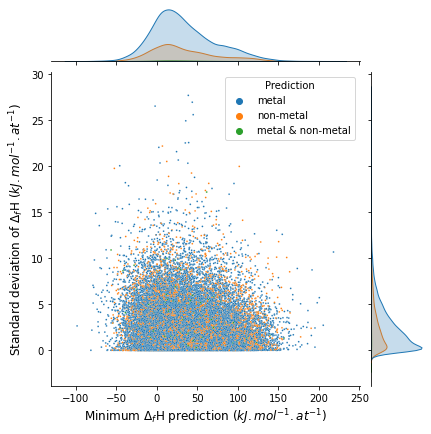

In [4]:
Etat = sns.jointplot(data = Analyse, x='min', y='std', s=3, hue='Prediction')
Etat.set_axis_labels('Minimum $\Delta_f$H prediction ($kJ.mol^{-1}.at^{-1}$)',
                     'Standard deviation of $\Delta_f$H ($kJ.mol^{-1}.at^{-1}$) ', fontsize=12)

plt.savefig('Image/AnalyseFig_DOS',dpi=1500)

In [5]:
print(Analyse['std'].round(1).value_counts().max())
Analyse['std'].round(1).value_counts()

2409


0.0     2409
0.1     1721
0.2      863
0.3      816
0.5      812
        ... 
22.6       1
24.9       1
20.0       1
20.7       1
20.1       1
Name: std, Length: 194, dtype: int64

In [6]:
np.average(Analyse['std'])

2.5108907015036355

In [7]:
np.mean(Analyse['std'])

2.5108907015036412

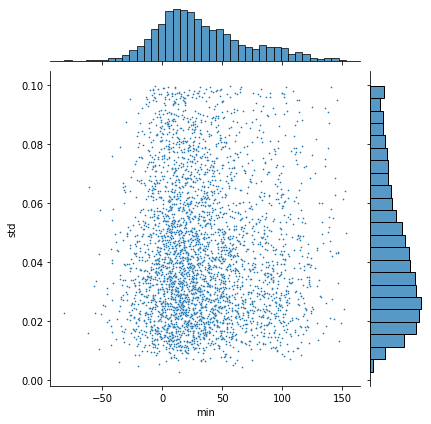

In [8]:
sns.jointplot(data = Analyse.loc[Analyse['std']<0.1], x='min', y='std', s=3)

In [46]:
Analyse['Prediction'].value_counts()

metal                23931
non-metal             7657
metal & non-metal      290
Name: Prediction, dtype: int64

## Extracting minium for a combination 

In [47]:
Analyse_combo = Analyse.copy()
Analyse_combo.reset_index()

,index,max,min,mean,std,X1,X2,X3,X4,SC,Config,Prediction
0,0,25.493355,22.184427,23.842634,1.643130,Ti,Zr,Hf,V,0.0,Quatern_Config_1,metal
1,1,24.589039,21.641833,23.123951,1.459574,Ti,Zr,Hf,V,0.0,Quatern_Config_2,metal
2,2,21.535056,17.384509,19.459027,2.061522,Ti,Zr,Hf,V,0.0,Quatern_Config_3,metal
3,3,14.461677,12.711378,13.587791,0.866493,Ti,Zr,Hf,Nb,0.0,Quatern_Config_1,metal
4,4,14.081603,12.616900,13.344459,0.727242,Ti,Zr,Hf,Nb,0.0,Quatern_Config_2,metal
...,...,...,...,...,...,...,...,...,...,...,...,...
31873,31873,32.347118,32.175345,32.263789,0.071498,Al,Si,Sn,Sb,0.0,Quatern_Config_2,metal
31874,31874,34.494818,34.447796,34.470449,0.014309,Al,Si,Sn,Sb,0.0,Quatern_Config_3,metal
31875,31875,39.783441,38.689473,39.235640,0.521468,P,Si,Sn,Sb,6.0,Quatern_Config_1,metal & non-metal
31876,31876,49.266732,48.624309,48.946375,0.308935,P,Si,Sn,Sb,6.0,Quatern_Config_2,metal & non-metal


In [48]:
Data_Combins = pd.DataFrame()

for i in df.index : 
    U = df.iloc[i]; A=U['X1']; B=U['X2']; C=U['X3']; D=U['X4']
    print(i, A, B, C, D)
    Combin = recherche(Analyse_combo, A, B, C, D) 
    Combin['eta_choix'] = Combin['SC']
    if Combin['SC'].max() > 0 : 
        Combin.loc[Combin.index, 'SC_choix'] = 'non-metal'
    else : Combin.loc[Combin.index, 'SC_choix'] = 'metal'
    Combin_min = Combin.loc[Combin['min']==Combin['min'].min()]
    Data_Combins = pd.concat([Data_Combins, Combin_min])
Data_Combins

0 Ti Zr Hf V
1 Ti Zr Hf Nb
2 Ti Zr Hf Ta
3 Ti Zr Hf Cr
4 Ti Zr Hf Mo
5 Ti Zr Hf W
6 Ti Zr Hf Sr
7 Ti Zr Hf Ba
8 Ti Zr Hf Y
9 Ti Zr Hf La
10 Ti Zr Hf Mn
11 Ti Zr Hf Fe
12 Ti Zr Hf Co
13 Ti Zr Hf Ni
14 Ti Zr Hf Cu
15 Ti Zr Hf Zn
16 Ti Zr Hf Al
17 Ti Zr Hf P
18 Ti Zr Hf Si
19 Ti Zr Hf Sn
20 Ti Zr Hf Sb
21 Ti Zr V Nb
22 Ti Zr V Ta
23 Ti Zr V Cr
24 Ti Zr V Mo
25 Ti Zr V W
26 Ti Zr V Sr
27 Ti Zr V Ba
28 Ti Zr V Y
29 Ti Zr V La
30 Ti Zr V Mn
31 Ti Zr V Fe
32 Ti Zr V Co
33 Ti Zr V Ni
34 Ti Zr V Cu
35 Ti Zr V Zn
36 Ti Zr V Al
37 Ti Zr V P
38 Ti Zr V Si
39 Ti Zr V Sn
40 Ti Zr V Sb
41 Ti Zr Nb Ta
42 Ti Zr Nb Cr
43 Ti Zr Nb Mo
44 Ti Zr Nb W
45 Ti Zr Nb Sr
46 Ti Zr Nb Ba
47 Ti Zr Nb Y
48 Ti Zr Nb La
49 Ti Zr Nb Mn
50 Ti Zr Nb Fe
51 Ti Zr Nb Co
52 Ti Zr Nb Ni
53 Ti Zr Nb Cu
54 Ti Zr Nb Zn
55 Ti Zr Nb Al
56 Ti Zr Nb P
57 Ti Zr Nb Si
58 Ti Zr Nb Sn
59 Ti Zr Nb Sb
60 Ti Zr Ta Cr
61 Ti Zr Ta Mo
62 Ti Zr Ta W
63 Ti Zr Ta Sr
64 Ti Zr Ta Ba
65 Ti Zr Ta Y
66 Ti Zr Ta La
67 Ti Zr Ta Mn
68 Ti Zr Ta Fe
69 Ti Z

539 Ti V Sr Sb
540 Ti V Ba Y
541 Ti V Ba La
542 Ti V Ba Mn
543 Ti V Ba Fe
544 Ti V Ba Co
545 Ti V Ba Ni
546 Ti V Ba Cu
547 Ti V Ba Zn
548 Ti V Ba Al
549 Ti V Ba P
550 Ti V Ba Si
551 Ti V Ba Sn
552 Ti V Ba Sb
553 Ti V Y La
554 Ti V Y Mn
555 Ti V Y Fe
556 Ti V Y Co
557 Ti V Y Ni
558 Ti V Y Cu
559 Ti V Y Zn
560 Ti V Y Al
561 Ti V Y P
562 Ti V Y Si
563 Ti V Y Sn
564 Ti V Y Sb
565 Ti V La Mn
566 Ti V La Fe
567 Ti V La Co
568 Ti V La Ni
569 Ti V La Cu
570 Ti V La Zn
571 Ti V La Al
572 Ti V La P
573 Ti V La Si
574 Ti V La Sn
575 Ti V La Sb
576 Ti V Mn Fe
577 Ti V Mn Co
578 Ti V Mn Ni
579 Ti V Mn Cu
580 Ti V Mn Zn
581 Ti V Mn Al
582 Ti V Mn P
583 Ti V Mn Si
584 Ti V Mn Sn
585 Ti V Mn Sb
586 Ti V Fe Co
587 Ti V Fe Ni
588 Ti V Fe Cu
589 Ti V Fe Zn
590 Ti V Fe Al
591 Ti V Fe P
592 Ti V Fe Si
593 Ti V Fe Sn
594 Ti V Fe Sb
595 Ti V Co Ni
596 Ti V Co Cu
597 Ti V Co Zn
598 Ti V Co Al
599 Ti V Co P
600 Ti V Co Si
601 Ti V Co Sn
602 Ti V Co Sb
603 Ti V Ni Cu
604 Ti V Ni Zn
605 Ti V Ni Al
606 Ti V Ni P


1069 Ti Cr Ni Sb
1070 Ti Cr Cu Zn
1071 Ti Cr Cu Al
1072 Ti Cr Cu P
1073 Ti Cr Cu Si
1074 Ti Cr Cu Sn
1075 Ti Cr Cu Sb
1076 Ti Cr Zn Al
1077 Ti Cr Zn P
1078 Ti Cr Zn Si
1079 Ti Cr Zn Sn
1080 Ti Cr Zn Sb
1081 Ti Cr Al P
1082 Ti Cr Al Si
1083 Ti Cr Al Sn
1084 Ti Cr Al Sb
1085 Ti Cr P Si
1086 Ti Cr P Sn
1087 Ti Cr P Sb
1088 Ti Cr Si Sn
1089 Ti Cr Si Sb
1090 Ti Cr Sn Sb
1091 Ti Mo W Sr
1092 Ti Mo W Ba
1093 Ti Mo W Y
1094 Ti Mo W La
1095 Ti Mo W Mn
1096 Ti Mo W Fe
1097 Ti Mo W Co
1098 Ti Mo W Ni
1099 Ti Mo W Cu
1100 Ti Mo W Zn
1101 Ti Mo W Al
1102 Ti Mo W P
1103 Ti Mo W Si
1104 Ti Mo W Sn
1105 Ti Mo W Sb
1106 Ti Mo Sr Ba
1107 Ti Mo Sr Y
1108 Ti Mo Sr La
1109 Ti Mo Sr Mn
1110 Ti Mo Sr Fe
1111 Ti Mo Sr Co
1112 Ti Mo Sr Ni
1113 Ti Mo Sr Cu
1114 Ti Mo Sr Zn
1115 Ti Mo Sr Al
1116 Ti Mo Sr P
1117 Ti Mo Sr Si
1118 Ti Mo Sr Sn
1119 Ti Mo Sr Sb
1120 Ti Mo Ba Y
1121 Ti Mo Ba La
1122 Ti Mo Ba Mn
1123 Ti Mo Ba Fe
1124 Ti Mo Ba Co
1125 Ti Mo Ba Ni
1126 Ti Mo Ba Cu
1127 Ti Mo Ba Zn
1128 Ti Mo Ba Al
1129 T

1576 Ti La Co Sn
1577 Ti La Co Sb
1578 Ti La Ni Cu
1579 Ti La Ni Zn
1580 Ti La Ni Al
1581 Ti La Ni P
1582 Ti La Ni Si
1583 Ti La Ni Sn
1584 Ti La Ni Sb
1585 Ti La Cu Zn
1586 Ti La Cu Al
1587 Ti La Cu P
1588 Ti La Cu Si
1589 Ti La Cu Sn
1590 Ti La Cu Sb
1591 Ti La Zn Al
1592 Ti La Zn P
1593 Ti La Zn Si
1594 Ti La Zn Sn
1595 Ti La Zn Sb
1596 Ti La Al P
1597 Ti La Al Si
1598 Ti La Al Sn
1599 Ti La Al Sb
1600 Ti La P Si
1601 Ti La P Sn
1602 Ti La P Sb
1603 Ti La Si Sn
1604 Ti La Si Sb
1605 Ti La Sn Sb
1606 Ti Mn Fe Co
1607 Ti Mn Fe Ni
1608 Ti Mn Fe Cu
1609 Ti Mn Fe Zn
1610 Ti Mn Fe Al
1611 Ti Mn Fe P
1612 Ti Mn Fe Si
1613 Ti Mn Fe Sn
1614 Ti Mn Fe Sb
1615 Ti Mn Co Ni
1616 Ti Mn Co Cu
1617 Ti Mn Co Zn
1618 Ti Mn Co Al
1619 Ti Mn Co P
1620 Ti Mn Co Si
1621 Ti Mn Co Sn
1622 Ti Mn Co Sb
1623 Ti Mn Ni Cu
1624 Ti Mn Ni Zn
1625 Ti Mn Ni Al
1626 Ti Mn Ni P
1627 Ti Mn Ni Si
1628 Ti Mn Ni Sn
1629 Ti Mn Ni Sb
1630 Ti Mn Cu Zn
1631 Ti Mn Cu Al
1632 Ti Mn Cu P
1633 Ti Mn Cu Si
1634 Ti Mn Cu Sn
1635 Ti 

2074 Zr V Sr Zn
2075 Zr V Sr Al
2076 Zr V Sr P
2077 Zr V Sr Si
2078 Zr V Sr Sn
2079 Zr V Sr Sb
2080 Zr V Ba Y
2081 Zr V Ba La
2082 Zr V Ba Mn
2083 Zr V Ba Fe
2084 Zr V Ba Co
2085 Zr V Ba Ni
2086 Zr V Ba Cu
2087 Zr V Ba Zn
2088 Zr V Ba Al
2089 Zr V Ba P
2090 Zr V Ba Si
2091 Zr V Ba Sn
2092 Zr V Ba Sb
2093 Zr V Y La
2094 Zr V Y Mn
2095 Zr V Y Fe
2096 Zr V Y Co
2097 Zr V Y Ni
2098 Zr V Y Cu
2099 Zr V Y Zn
2100 Zr V Y Al
2101 Zr V Y P
2102 Zr V Y Si
2103 Zr V Y Sn
2104 Zr V Y Sb
2105 Zr V La Mn
2106 Zr V La Fe
2107 Zr V La Co
2108 Zr V La Ni
2109 Zr V La Cu
2110 Zr V La Zn
2111 Zr V La Al
2112 Zr V La P
2113 Zr V La Si
2114 Zr V La Sn
2115 Zr V La Sb
2116 Zr V Mn Fe
2117 Zr V Mn Co
2118 Zr V Mn Ni
2119 Zr V Mn Cu
2120 Zr V Mn Zn
2121 Zr V Mn Al
2122 Zr V Mn P
2123 Zr V Mn Si
2124 Zr V Mn Sn
2125 Zr V Mn Sb
2126 Zr V Fe Co
2127 Zr V Fe Ni
2128 Zr V Fe Cu
2129 Zr V Fe Zn
2130 Zr V Fe Al
2131 Zr V Fe P
2132 Zr V Fe Si
2133 Zr V Fe Sn
2134 Zr V Fe Sb
2135 Zr V Co Ni
2136 Zr V Co Cu
2137 Zr V C

2572 Zr Cr La P
2573 Zr Cr La Si
2574 Zr Cr La Sn
2575 Zr Cr La Sb
2576 Zr Cr Mn Fe
2577 Zr Cr Mn Co
2578 Zr Cr Mn Ni
2579 Zr Cr Mn Cu
2580 Zr Cr Mn Zn
2581 Zr Cr Mn Al
2582 Zr Cr Mn P
2583 Zr Cr Mn Si
2584 Zr Cr Mn Sn
2585 Zr Cr Mn Sb
2586 Zr Cr Fe Co
2587 Zr Cr Fe Ni
2588 Zr Cr Fe Cu
2589 Zr Cr Fe Zn
2590 Zr Cr Fe Al
2591 Zr Cr Fe P
2592 Zr Cr Fe Si
2593 Zr Cr Fe Sn
2594 Zr Cr Fe Sb
2595 Zr Cr Co Ni
2596 Zr Cr Co Cu
2597 Zr Cr Co Zn
2598 Zr Cr Co Al
2599 Zr Cr Co P
2600 Zr Cr Co Si
2601 Zr Cr Co Sn
2602 Zr Cr Co Sb
2603 Zr Cr Ni Cu
2604 Zr Cr Ni Zn
2605 Zr Cr Ni Al
2606 Zr Cr Ni P
2607 Zr Cr Ni Si
2608 Zr Cr Ni Sn
2609 Zr Cr Ni Sb
2610 Zr Cr Cu Zn
2611 Zr Cr Cu Al
2612 Zr Cr Cu P
2613 Zr Cr Cu Si
2614 Zr Cr Cu Sn
2615 Zr Cr Cu Sb
2616 Zr Cr Zn Al
2617 Zr Cr Zn P
2618 Zr Cr Zn Si
2619 Zr Cr Zn Sn
2620 Zr Cr Zn Sb
2621 Zr Cr Al P
2622 Zr Cr Al Si
2623 Zr Cr Al Sn
2624 Zr Cr Al Sb
2625 Zr Cr P Si
2626 Zr Cr P Sn
2627 Zr Cr P Sb
2628 Zr Cr Si Sn
2629 Zr Cr Si Sb
2630 Zr Cr Sn Sb
2631 Zr 

3079 Zr Y Zn Sn
3080 Zr Y Zn Sb
3081 Zr Y Al P
3082 Zr Y Al Si
3083 Zr Y Al Sn
3084 Zr Y Al Sb
3085 Zr Y P Si
3086 Zr Y P Sn
3087 Zr Y P Sb
3088 Zr Y Si Sn
3089 Zr Y Si Sb
3090 Zr Y Sn Sb
3091 Zr La Mn Fe
3092 Zr La Mn Co
3093 Zr La Mn Ni
3094 Zr La Mn Cu
3095 Zr La Mn Zn
3096 Zr La Mn Al
3097 Zr La Mn P
3098 Zr La Mn Si
3099 Zr La Mn Sn
3100 Zr La Mn Sb
3101 Zr La Fe Co
3102 Zr La Fe Ni
3103 Zr La Fe Cu
3104 Zr La Fe Zn
3105 Zr La Fe Al
3106 Zr La Fe P
3107 Zr La Fe Si
3108 Zr La Fe Sn
3109 Zr La Fe Sb
3110 Zr La Co Ni
3111 Zr La Co Cu
3112 Zr La Co Zn
3113 Zr La Co Al
3114 Zr La Co P
3115 Zr La Co Si
3116 Zr La Co Sn
3117 Zr La Co Sb
3118 Zr La Ni Cu
3119 Zr La Ni Zn
3120 Zr La Ni Al
3121 Zr La Ni P
3122 Zr La Ni Si
3123 Zr La Ni Sn
3124 Zr La Ni Sb
3125 Zr La Cu Zn
3126 Zr La Cu Al
3127 Zr La Cu P
3128 Zr La Cu Si
3129 Zr La Cu Sn
3130 Zr La Cu Sb
3131 Zr La Zn Al
3132 Zr La Zn P
3133 Zr La Zn Si
3134 Zr La Zn Sn
3135 Zr La Zn Sb
3136 Zr La Al P
3137 Zr La Al Si
3138 Zr La Al Sn
313

3602 Hf Nb Y P
3603 Hf Nb Y Si
3604 Hf Nb Y Sn
3605 Hf Nb Y Sb
3606 Hf Nb La Mn
3607 Hf Nb La Fe
3608 Hf Nb La Co
3609 Hf Nb La Ni
3610 Hf Nb La Cu
3611 Hf Nb La Zn
3612 Hf Nb La Al
3613 Hf Nb La P
3614 Hf Nb La Si
3615 Hf Nb La Sn
3616 Hf Nb La Sb
3617 Hf Nb Mn Fe
3618 Hf Nb Mn Co
3619 Hf Nb Mn Ni
3620 Hf Nb Mn Cu
3621 Hf Nb Mn Zn
3622 Hf Nb Mn Al
3623 Hf Nb Mn P
3624 Hf Nb Mn Si
3625 Hf Nb Mn Sn
3626 Hf Nb Mn Sb
3627 Hf Nb Fe Co
3628 Hf Nb Fe Ni
3629 Hf Nb Fe Cu
3630 Hf Nb Fe Zn
3631 Hf Nb Fe Al
3632 Hf Nb Fe P
3633 Hf Nb Fe Si
3634 Hf Nb Fe Sn
3635 Hf Nb Fe Sb
3636 Hf Nb Co Ni
3637 Hf Nb Co Cu
3638 Hf Nb Co Zn
3639 Hf Nb Co Al
3640 Hf Nb Co P
3641 Hf Nb Co Si
3642 Hf Nb Co Sn
3643 Hf Nb Co Sb
3644 Hf Nb Ni Cu
3645 Hf Nb Ni Zn
3646 Hf Nb Ni Al
3647 Hf Nb Ni P
3648 Hf Nb Ni Si
3649 Hf Nb Ni Sn
3650 Hf Nb Ni Sb
3651 Hf Nb Cu Zn
3652 Hf Nb Cu Al
3653 Hf Nb Cu P
3654 Hf Nb Cu Si
3655 Hf Nb Cu Sn
3656 Hf Nb Cu Sb
3657 Hf Nb Zn Al
3658 Hf Nb Zn P
3659 Hf Nb Zn Si
3660 Hf Nb Zn Sn
3661 Hf N

4101 Hf W Ba Cu
4102 Hf W Ba Zn
4103 Hf W Ba Al
4104 Hf W Ba P
4105 Hf W Ba Si
4106 Hf W Ba Sn
4107 Hf W Ba Sb
4108 Hf W Y La
4109 Hf W Y Mn
4110 Hf W Y Fe
4111 Hf W Y Co
4112 Hf W Y Ni
4113 Hf W Y Cu
4114 Hf W Y Zn
4115 Hf W Y Al
4116 Hf W Y P
4117 Hf W Y Si
4118 Hf W Y Sn
4119 Hf W Y Sb
4120 Hf W La Mn
4121 Hf W La Fe
4122 Hf W La Co
4123 Hf W La Ni
4124 Hf W La Cu
4125 Hf W La Zn
4126 Hf W La Al
4127 Hf W La P
4128 Hf W La Si
4129 Hf W La Sn
4130 Hf W La Sb
4131 Hf W Mn Fe
4132 Hf W Mn Co
4133 Hf W Mn Ni
4134 Hf W Mn Cu
4135 Hf W Mn Zn
4136 Hf W Mn Al
4137 Hf W Mn P
4138 Hf W Mn Si
4139 Hf W Mn Sn
4140 Hf W Mn Sb
4141 Hf W Fe Co
4142 Hf W Fe Ni
4143 Hf W Fe Cu
4144 Hf W Fe Zn
4145 Hf W Fe Al
4146 Hf W Fe P
4147 Hf W Fe Si
4148 Hf W Fe Sn
4149 Hf W Fe Sb
4150 Hf W Co Ni
4151 Hf W Co Cu
4152 Hf W Co Zn
4153 Hf W Co Al
4154 Hf W Co P
4155 Hf W Co Si
4156 Hf W Co Sn
4157 Hf W Co Sb
4158 Hf W Ni Cu
4159 Hf W Ni Zn
4160 Hf W Ni Al
4161 Hf W Ni P
4162 Hf W Ni Si
4163 Hf W Ni Sn
4164 Hf W N

4609 Hf Cu Zn Sn
4610 Hf Cu Zn Sb
4611 Hf Cu Al P
4612 Hf Cu Al Si
4613 Hf Cu Al Sn
4614 Hf Cu Al Sb
4615 Hf Cu P Si
4616 Hf Cu P Sn
4617 Hf Cu P Sb
4618 Hf Cu Si Sn
4619 Hf Cu Si Sb
4620 Hf Cu Sn Sb
4621 Hf Zn Al P
4622 Hf Zn Al Si
4623 Hf Zn Al Sn
4624 Hf Zn Al Sb
4625 Hf Zn P Si
4626 Hf Zn P Sn
4627 Hf Zn P Sb
4628 Hf Zn Si Sn
4629 Hf Zn Si Sb
4630 Hf Zn Sn Sb
4631 Hf Al P Si
4632 Hf Al P Sn
4633 Hf Al P Sb
4634 Hf Al Si Sn
4635 Hf Al Si Sb
4636 Hf Al Sn Sb
4637 Hf P Si Sn
4638 Hf P Si Sb
4639 Hf P Sn Sb
4640 Hf Si Sn Sb
4641 V Nb Ta Cr
4642 V Nb Ta Mo
4643 V Nb Ta W
4644 V Nb Ta Sr
4645 V Nb Ta Ba
4646 V Nb Ta Y
4647 V Nb Ta La
4648 V Nb Ta Mn
4649 V Nb Ta Fe
4650 V Nb Ta Co
4651 V Nb Ta Ni
4652 V Nb Ta Cu
4653 V Nb Ta Zn
4654 V Nb Ta Al
4655 V Nb Ta P
4656 V Nb Ta Si
4657 V Nb Ta Sn
4658 V Nb Ta Sb
4659 V Nb Cr Mo
4660 V Nb Cr W
4661 V Nb Cr Sr
4662 V Nb Cr Ba
4663 V Nb Cr Y
4664 V Nb Cr La
4665 V Nb Cr Mn
4666 V Nb Cr Fe
4667 V Nb Cr Co
4668 V Nb Cr Ni
4669 V Nb Cr Cu
4670 V Nb C

5142 V Mo Ba Sb
5143 V Mo Y La
5144 V Mo Y Mn
5145 V Mo Y Fe
5146 V Mo Y Co
5147 V Mo Y Ni
5148 V Mo Y Cu
5149 V Mo Y Zn
5150 V Mo Y Al
5151 V Mo Y P
5152 V Mo Y Si
5153 V Mo Y Sn
5154 V Mo Y Sb
5155 V Mo La Mn
5156 V Mo La Fe
5157 V Mo La Co
5158 V Mo La Ni
5159 V Mo La Cu
5160 V Mo La Zn
5161 V Mo La Al
5162 V Mo La P
5163 V Mo La Si
5164 V Mo La Sn
5165 V Mo La Sb
5166 V Mo Mn Fe
5167 V Mo Mn Co
5168 V Mo Mn Ni
5169 V Mo Mn Cu
5170 V Mo Mn Zn
5171 V Mo Mn Al
5172 V Mo Mn P
5173 V Mo Mn Si
5174 V Mo Mn Sn
5175 V Mo Mn Sb
5176 V Mo Fe Co
5177 V Mo Fe Ni
5178 V Mo Fe Cu
5179 V Mo Fe Zn
5180 V Mo Fe Al
5181 V Mo Fe P
5182 V Mo Fe Si
5183 V Mo Fe Sn
5184 V Mo Fe Sb
5185 V Mo Co Ni
5186 V Mo Co Cu
5187 V Mo Co Zn
5188 V Mo Co Al
5189 V Mo Co P
5190 V Mo Co Si
5191 V Mo Co Sn
5192 V Mo Co Sb
5193 V Mo Ni Cu
5194 V Mo Ni Zn
5195 V Mo Ni Al
5196 V Mo Ni P
5197 V Mo Ni Si
5198 V Mo Ni Sn
5199 V Mo Ni Sb
5200 V Mo Cu Zn
5201 V Mo Cu Al
5202 V Mo Cu P
5203 V Mo Cu Si
5204 V Mo Cu Sn
5205 V Mo C

5679 V Fe Cu Si
5680 V Fe Cu Sn
5681 V Fe Cu Sb
5682 V Fe Zn Al
5683 V Fe Zn P
5684 V Fe Zn Si
5685 V Fe Zn Sn
5686 V Fe Zn Sb
5687 V Fe Al P
5688 V Fe Al Si
5689 V Fe Al Sn
5690 V Fe Al Sb
5691 V Fe P Si
5692 V Fe P Sn
5693 V Fe P Sb
5694 V Fe Si Sn
5695 V Fe Si Sb
5696 V Fe Sn Sb
5697 V Co Ni Cu
5698 V Co Ni Zn
5699 V Co Ni Al
5700 V Co Ni P
5701 V Co Ni Si
5702 V Co Ni Sn
5703 V Co Ni Sb
5704 V Co Cu Zn
5705 V Co Cu Al
5706 V Co Cu P
5707 V Co Cu Si
5708 V Co Cu Sn
5709 V Co Cu Sb
5710 V Co Zn Al
5711 V Co Zn P
5712 V Co Zn Si
5713 V Co Zn Sn
5714 V Co Zn Sb
5715 V Co Al P
5716 V Co Al Si
5717 V Co Al Sn
5718 V Co Al Sb
5719 V Co P Si
5720 V Co P Sn
5721 V Co P Sb
5722 V Co Si Sn
5723 V Co Si Sb
5724 V Co Sn Sb
5725 V Ni Cu Zn
5726 V Ni Cu Al
5727 V Ni Cu P
5728 V Ni Cu Si
5729 V Ni Cu Sn
5730 V Ni Cu Sb
5731 V Ni Zn Al
5732 V Ni Zn P
5733 V Ni Zn Si
5734 V Ni Zn Sn
5735 V Ni Zn Sb
5736 V Ni Al P
5737 V Ni Al Si
5738 V Ni Al Sn
5739 V Ni Al Sb
5740 V Ni P Si
5741 V Ni P Sn
5742 V Ni

6179 Nb Mo Zn Sb
6180 Nb Mo Al P
6181 Nb Mo Al Si
6182 Nb Mo Al Sn
6183 Nb Mo Al Sb
6184 Nb Mo P Si
6185 Nb Mo P Sn
6186 Nb Mo P Sb
6187 Nb Mo Si Sn
6188 Nb Mo Si Sb
6189 Nb Mo Sn Sb
6190 Nb W Sr Ba
6191 Nb W Sr Y
6192 Nb W Sr La
6193 Nb W Sr Mn
6194 Nb W Sr Fe
6195 Nb W Sr Co
6196 Nb W Sr Ni
6197 Nb W Sr Cu
6198 Nb W Sr Zn
6199 Nb W Sr Al
6200 Nb W Sr P
6201 Nb W Sr Si
6202 Nb W Sr Sn
6203 Nb W Sr Sb
6204 Nb W Ba Y
6205 Nb W Ba La
6206 Nb W Ba Mn
6207 Nb W Ba Fe
6208 Nb W Ba Co
6209 Nb W Ba Ni
6210 Nb W Ba Cu
6211 Nb W Ba Zn
6212 Nb W Ba Al
6213 Nb W Ba P
6214 Nb W Ba Si
6215 Nb W Ba Sn
6216 Nb W Ba Sb
6217 Nb W Y La
6218 Nb W Y Mn
6219 Nb W Y Fe
6220 Nb W Y Co
6221 Nb W Y Ni
6222 Nb W Y Cu
6223 Nb W Y Zn
6224 Nb W Y Al
6225 Nb W Y P
6226 Nb W Y Si
6227 Nb W Y Sn
6228 Nb W Y Sb
6229 Nb W La Mn
6230 Nb W La Fe
6231 Nb W La Co
6232 Nb W La Ni
6233 Nb W La Cu
6234 Nb W La Zn
6235 Nb W La Al
6236 Nb W La P
6237 Nb W La Si
6238 Nb W La Sn
6239 Nb W La Sb
6240 Nb W Mn Fe
6241 Nb W Mn Co
624

6692 Nb Co Si Sb
6693 Nb Co Sn Sb
6694 Nb Ni Cu Zn
6695 Nb Ni Cu Al
6696 Nb Ni Cu P
6697 Nb Ni Cu Si
6698 Nb Ni Cu Sn
6699 Nb Ni Cu Sb
6700 Nb Ni Zn Al
6701 Nb Ni Zn P
6702 Nb Ni Zn Si
6703 Nb Ni Zn Sn
6704 Nb Ni Zn Sb
6705 Nb Ni Al P
6706 Nb Ni Al Si
6707 Nb Ni Al Sn
6708 Nb Ni Al Sb
6709 Nb Ni P Si
6710 Nb Ni P Sn
6711 Nb Ni P Sb
6712 Nb Ni Si Sn
6713 Nb Ni Si Sb
6714 Nb Ni Sn Sb
6715 Nb Cu Zn Al
6716 Nb Cu Zn P
6717 Nb Cu Zn Si
6718 Nb Cu Zn Sn
6719 Nb Cu Zn Sb
6720 Nb Cu Al P
6721 Nb Cu Al Si
6722 Nb Cu Al Sn
6723 Nb Cu Al Sb
6724 Nb Cu P Si
6725 Nb Cu P Sn
6726 Nb Cu P Sb
6727 Nb Cu Si Sn
6728 Nb Cu Si Sb
6729 Nb Cu Sn Sb
6730 Nb Zn Al P
6731 Nb Zn Al Si
6732 Nb Zn Al Sn
6733 Nb Zn Al Sb
6734 Nb Zn P Si
6735 Nb Zn P Sn
6736 Nb Zn P Sb
6737 Nb Zn Si Sn
6738 Nb Zn Si Sb
6739 Nb Zn Sn Sb
6740 Nb Al P Si
6741 Nb Al P Sn
6742 Nb Al P Sb
6743 Nb Al Si Sn
6744 Nb Al Si Sb
6745 Nb Al Sn Sb
6746 Nb P Si Sn
6747 Nb P Si Sb
6748 Nb P Sn Sb
6749 Nb Si Sn Sb
6750 Ta Cr Mo W
6751 Ta Cr Mo Sr
67

7206 Ta Ba Y Ni
7207 Ta Ba Y Cu
7208 Ta Ba Y Zn
7209 Ta Ba Y Al
7210 Ta Ba Y P
7211 Ta Ba Y Si
7212 Ta Ba Y Sn
7213 Ta Ba Y Sb
7214 Ta Ba La Mn
7215 Ta Ba La Fe
7216 Ta Ba La Co
7217 Ta Ba La Ni
7218 Ta Ba La Cu
7219 Ta Ba La Zn
7220 Ta Ba La Al
7221 Ta Ba La P
7222 Ta Ba La Si
7223 Ta Ba La Sn
7224 Ta Ba La Sb
7225 Ta Ba Mn Fe
7226 Ta Ba Mn Co
7227 Ta Ba Mn Ni
7228 Ta Ba Mn Cu
7229 Ta Ba Mn Zn
7230 Ta Ba Mn Al
7231 Ta Ba Mn P
7232 Ta Ba Mn Si
7233 Ta Ba Mn Sn
7234 Ta Ba Mn Sb
7235 Ta Ba Fe Co
7236 Ta Ba Fe Ni
7237 Ta Ba Fe Cu
7238 Ta Ba Fe Zn
7239 Ta Ba Fe Al
7240 Ta Ba Fe P
7241 Ta Ba Fe Si
7242 Ta Ba Fe Sn
7243 Ta Ba Fe Sb
7244 Ta Ba Co Ni
7245 Ta Ba Co Cu
7246 Ta Ba Co Zn
7247 Ta Ba Co Al
7248 Ta Ba Co P
7249 Ta Ba Co Si
7250 Ta Ba Co Sn
7251 Ta Ba Co Sb
7252 Ta Ba Ni Cu
7253 Ta Ba Ni Zn
7254 Ta Ba Ni Al
7255 Ta Ba Ni P
7256 Ta Ba Ni Si
7257 Ta Ba Ni Sn
7258 Ta Ba Ni Sb
7259 Ta Ba Cu Zn
7260 Ta Ba Cu Al
7261 Ta Ba Cu P
7262 Ta Ba Cu Si
7263 Ta Ba Cu Sn
7264 Ta Ba Cu Sb
7265 Ta Ba Z

7714 Cr W Y Mn
7715 Cr W Y Fe
7716 Cr W Y Co
7717 Cr W Y Ni
7718 Cr W Y Cu
7719 Cr W Y Zn
7720 Cr W Y Al
7721 Cr W Y P
7722 Cr W Y Si
7723 Cr W Y Sn
7724 Cr W Y Sb
7725 Cr W La Mn
7726 Cr W La Fe
7727 Cr W La Co
7728 Cr W La Ni
7729 Cr W La Cu
7730 Cr W La Zn
7731 Cr W La Al
7732 Cr W La P
7733 Cr W La Si
7734 Cr W La Sn
7735 Cr W La Sb
7736 Cr W Mn Fe
7737 Cr W Mn Co
7738 Cr W Mn Ni
7739 Cr W Mn Cu
7740 Cr W Mn Zn
7741 Cr W Mn Al
7742 Cr W Mn P
7743 Cr W Mn Si
7744 Cr W Mn Sn
7745 Cr W Mn Sb
7746 Cr W Fe Co
7747 Cr W Fe Ni
7748 Cr W Fe Cu
7749 Cr W Fe Zn
7750 Cr W Fe Al
7751 Cr W Fe P
7752 Cr W Fe Si
7753 Cr W Fe Sn
7754 Cr W Fe Sb
7755 Cr W Co Ni
7756 Cr W Co Cu
7757 Cr W Co Zn
7758 Cr W Co Al
7759 Cr W Co P
7760 Cr W Co Si
7761 Cr W Co Sn
7762 Cr W Co Sb
7763 Cr W Ni Cu
7764 Cr W Ni Zn
7765 Cr W Ni Al
7766 Cr W Ni P
7767 Cr W Ni Si
7768 Cr W Ni Sn
7769 Cr W Ni Sb
7770 Cr W Cu Zn
7771 Cr W Cu Al
7772 Cr W Cu P
7773 Cr W Cu Si
7774 Cr W Cu Sn
7775 Cr W Cu Sb
7776 Cr W Zn Al
7777 Cr W 

8219 Cr Cu Al Sb
8220 Cr Cu P Si
8221 Cr Cu P Sn
8222 Cr Cu P Sb
8223 Cr Cu Si Sn
8224 Cr Cu Si Sb
8225 Cr Cu Sn Sb
8226 Cr Zn Al P
8227 Cr Zn Al Si
8228 Cr Zn Al Sn
8229 Cr Zn Al Sb
8230 Cr Zn P Si
8231 Cr Zn P Sn
8232 Cr Zn P Sb
8233 Cr Zn Si Sn
8234 Cr Zn Si Sb
8235 Cr Zn Sn Sb
8236 Cr Al P Si
8237 Cr Al P Sn
8238 Cr Al P Sb
8239 Cr Al Si Sn
8240 Cr Al Si Sb
8241 Cr Al Sn Sb
8242 Cr P Si Sn
8243 Cr P Si Sb
8244 Cr P Sn Sb
8245 Cr Si Sn Sb
8246 Mo W Sr Ba
8247 Mo W Sr Y
8248 Mo W Sr La
8249 Mo W Sr Mn
8250 Mo W Sr Fe
8251 Mo W Sr Co
8252 Mo W Sr Ni
8253 Mo W Sr Cu
8254 Mo W Sr Zn
8255 Mo W Sr Al
8256 Mo W Sr P
8257 Mo W Sr Si
8258 Mo W Sr Sn
8259 Mo W Sr Sb
8260 Mo W Ba Y
8261 Mo W Ba La
8262 Mo W Ba Mn
8263 Mo W Ba Fe
8264 Mo W Ba Co
8265 Mo W Ba Ni
8266 Mo W Ba Cu
8267 Mo W Ba Zn
8268 Mo W Ba Al
8269 Mo W Ba P
8270 Mo W Ba Si
8271 Mo W Ba Sn
8272 Mo W Ba Sb
8273 Mo W Y La
8274 Mo W Y Mn
8275 Mo W Y Fe
8276 Mo W Y Co
8277 Mo W Y Ni
8278 Mo W Y Cu
8279 Mo W Y Zn
8280 Mo W Y Al
8281 M

8719 Mo Fe Si Sn
8720 Mo Fe Si Sb
8721 Mo Fe Sn Sb
8722 Mo Co Ni Cu
8723 Mo Co Ni Zn
8724 Mo Co Ni Al
8725 Mo Co Ni P
8726 Mo Co Ni Si
8727 Mo Co Ni Sn
8728 Mo Co Ni Sb
8729 Mo Co Cu Zn
8730 Mo Co Cu Al
8731 Mo Co Cu P
8732 Mo Co Cu Si
8733 Mo Co Cu Sn
8734 Mo Co Cu Sb
8735 Mo Co Zn Al
8736 Mo Co Zn P
8737 Mo Co Zn Si
8738 Mo Co Zn Sn
8739 Mo Co Zn Sb
8740 Mo Co Al P
8741 Mo Co Al Si
8742 Mo Co Al Sn
8743 Mo Co Al Sb
8744 Mo Co P Si
8745 Mo Co P Sn
8746 Mo Co P Sb
8747 Mo Co Si Sn
8748 Mo Co Si Sb
8749 Mo Co Sn Sb
8750 Mo Ni Cu Zn
8751 Mo Ni Cu Al
8752 Mo Ni Cu P
8753 Mo Ni Cu Si
8754 Mo Ni Cu Sn
8755 Mo Ni Cu Sb
8756 Mo Ni Zn Al
8757 Mo Ni Zn P
8758 Mo Ni Zn Si
8759 Mo Ni Zn Sn
8760 Mo Ni Zn Sb
8761 Mo Ni Al P
8762 Mo Ni Al Si
8763 Mo Ni Al Sn
8764 Mo Ni Al Sb
8765 Mo Ni P Si
8766 Mo Ni P Sn
8767 Mo Ni P Sb
8768 Mo Ni Si Sn
8769 Mo Ni Si Sb
8770 Mo Ni Sn Sb
8771 Mo Cu Zn Al
8772 Mo Cu Zn P
8773 Mo Cu Zn Si
8774 Mo Cu Zn Sn
8775 Mo Cu Zn Sb
8776 Mo Cu Al P
8777 Mo Cu Al Si
8778 Mo Cu A

9252 W Al P Sn
9253 W Al P Sb
9254 W Al Si Sn
9255 W Al Si Sb
9256 W Al Sn Sb
9257 W P Si Sn
9258 W P Si Sb
9259 W P Sn Sb
9260 W Si Sn Sb
9261 Sr Ba Y La
9262 Sr Ba Y Mn
9263 Sr Ba Y Fe
9264 Sr Ba Y Co
9265 Sr Ba Y Ni
9266 Sr Ba Y Cu
9267 Sr Ba Y Zn
9268 Sr Ba Y Al
9269 Sr Ba Y P
9270 Sr Ba Y Si
9271 Sr Ba Y Sn
9272 Sr Ba Y Sb
9273 Sr Ba La Mn
9274 Sr Ba La Fe
9275 Sr Ba La Co
9276 Sr Ba La Ni
9277 Sr Ba La Cu
9278 Sr Ba La Zn
9279 Sr Ba La Al
9280 Sr Ba La P
9281 Sr Ba La Si
9282 Sr Ba La Sn
9283 Sr Ba La Sb
9284 Sr Ba Mn Fe
9285 Sr Ba Mn Co
9286 Sr Ba Mn Ni
9287 Sr Ba Mn Cu
9288 Sr Ba Mn Zn
9289 Sr Ba Mn Al
9290 Sr Ba Mn P
9291 Sr Ba Mn Si
9292 Sr Ba Mn Sn
9293 Sr Ba Mn Sb
9294 Sr Ba Fe Co
9295 Sr Ba Fe Ni
9296 Sr Ba Fe Cu
9297 Sr Ba Fe Zn
9298 Sr Ba Fe Al
9299 Sr Ba Fe P
9300 Sr Ba Fe Si
9301 Sr Ba Fe Sn
9302 Sr Ba Fe Sb
9303 Sr Ba Co Ni
9304 Sr Ba Co Cu
9305 Sr Ba Co Zn
9306 Sr Ba Co Al
9307 Sr Ba Co P
9308 Sr Ba Co Si
9309 Sr Ba Co Sn
9310 Sr Ba Co Sb
9311 Sr Ba Ni Cu
9312 Sr Ba 

9763 Ba Mn Ni Cu
9764 Ba Mn Ni Zn
9765 Ba Mn Ni Al
9766 Ba Mn Ni P
9767 Ba Mn Ni Si
9768 Ba Mn Ni Sn
9769 Ba Mn Ni Sb
9770 Ba Mn Cu Zn
9771 Ba Mn Cu Al
9772 Ba Mn Cu P
9773 Ba Mn Cu Si
9774 Ba Mn Cu Sn
9775 Ba Mn Cu Sb
9776 Ba Mn Zn Al
9777 Ba Mn Zn P
9778 Ba Mn Zn Si
9779 Ba Mn Zn Sn
9780 Ba Mn Zn Sb
9781 Ba Mn Al P
9782 Ba Mn Al Si
9783 Ba Mn Al Sn
9784 Ba Mn Al Sb
9785 Ba Mn P Si
9786 Ba Mn P Sn
9787 Ba Mn P Sb
9788 Ba Mn Si Sn
9789 Ba Mn Si Sb
9790 Ba Mn Sn Sb
9791 Ba Fe Co Ni
9792 Ba Fe Co Cu
9793 Ba Fe Co Zn
9794 Ba Fe Co Al
9795 Ba Fe Co P
9796 Ba Fe Co Si
9797 Ba Fe Co Sn
9798 Ba Fe Co Sb
9799 Ba Fe Ni Cu
9800 Ba Fe Ni Zn
9801 Ba Fe Ni Al
9802 Ba Fe Ni P
9803 Ba Fe Ni Si
9804 Ba Fe Ni Sn
9805 Ba Fe Ni Sb
9806 Ba Fe Cu Zn
9807 Ba Fe Cu Al
9808 Ba Fe Cu P
9809 Ba Fe Cu Si
9810 Ba Fe Cu Sn
9811 Ba Fe Cu Sb
9812 Ba Fe Zn Al
9813 Ba Fe Zn P
9814 Ba Fe Zn Si
9815 Ba Fe Zn Sn
9816 Ba Fe Zn Sb
9817 Ba Fe Al P
9818 Ba Fe Al Si
9819 Ba Fe Al Sn
9820 Ba Fe Al Sb
9821 Ba Fe P Si
9822 Ba Fe

10252 La Ni Al Si
10253 La Ni Al Sn
10254 La Ni Al Sb
10255 La Ni P Si
10256 La Ni P Sn
10257 La Ni P Sb
10258 La Ni Si Sn
10259 La Ni Si Sb
10260 La Ni Sn Sb
10261 La Cu Zn Al
10262 La Cu Zn P
10263 La Cu Zn Si
10264 La Cu Zn Sn
10265 La Cu Zn Sb
10266 La Cu Al P
10267 La Cu Al Si
10268 La Cu Al Sn
10269 La Cu Al Sb
10270 La Cu P Si
10271 La Cu P Sn
10272 La Cu P Sb
10273 La Cu Si Sn
10274 La Cu Si Sb
10275 La Cu Sn Sb
10276 La Zn Al P
10277 La Zn Al Si
10278 La Zn Al Sn
10279 La Zn Al Sb
10280 La Zn P Si
10281 La Zn P Sn
10282 La Zn P Sb
10283 La Zn Si Sn
10284 La Zn Si Sb
10285 La Zn Sn Sb
10286 La Al P Si
10287 La Al P Sn
10288 La Al P Sb
10289 La Al Si Sn
10290 La Al Si Sb
10291 La Al Sn Sb
10292 La P Si Sn
10293 La P Si Sb
10294 La P Sn Sb
10295 La Si Sn Sb
10296 Mn Fe Co Ni
10297 Mn Fe Co Cu
10298 Mn Fe Co Zn
10299 Mn Fe Co Al
10300 Mn Fe Co P
10301 Mn Fe Co Si
10302 Mn Fe Co Sn
10303 Mn Fe Co Sb
10304 Mn Fe Ni Cu
10305 Mn Fe Ni Zn
10306 Mn Fe Ni Al
10307 Mn Fe Ni P
10308 Mn Fe 

,max,min,mean,std,X1,X2,X3,X4,SC,Config,Prediction,eta_choix,SC_choix
2,21.535056,17.384509,19.459027,2.061522,Ti,Zr,Hf,V,0.0,Quatern_Config_3,metal,0.0,metal
5,12.745290,11.423450,12.087486,0.648496,Ti,Zr,Hf,Nb,0.0,Quatern_Config_3,metal,0.0,metal
6,14.435843,13.224447,13.830995,0.599891,Ti,Zr,Hf,Ta,0.0,Quatern_Config_1,metal,0.0,metal
11,23.736278,21.407520,22.577699,1.155591,Ti,Zr,Hf,Cr,8.0,Quatern_Config_3,non-metal,8.0,non-metal
14,9.194421,7.671401,8.433321,0.757661,Ti,Zr,Hf,Mo,8.0,Quatern_Config_3,non-metal,8.0,non-metal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31865,33.572886,32.670113,33.116848,0.436213,Al,P,Si,Sn,0.0,Quatern_Config_3,metal,0.0,metal
31868,38.076879,36.714654,37.393173,0.661425,Al,P,Si,Sb,0.0,Quatern_Config_3,metal,0.0,metal
31870,33.210597,30.994966,32.097806,1.091865,Al,P,Sn,Sb,0.0,Quatern_Config_2,metal,0.0,metal
31872,30.340457,29.525266,29.921504,0.395397,Al,Si,Sn,Sb,0.0,Quatern_Config_1,metal,0.0,metal


In [49]:
Data_Combins

,max,min,mean,std,X1,X2,X3,X4,SC,Config,Prediction,eta_choix,SC_choix
2,21.535056,17.384509,19.459027,2.061522,Ti,Zr,Hf,V,0.0,Quatern_Config_3,metal,0.0,metal
5,12.745290,11.423450,12.087486,0.648496,Ti,Zr,Hf,Nb,0.0,Quatern_Config_3,metal,0.0,metal
6,14.435843,13.224447,13.830995,0.599891,Ti,Zr,Hf,Ta,0.0,Quatern_Config_1,metal,0.0,metal
11,23.736278,21.407520,22.577699,1.155591,Ti,Zr,Hf,Cr,8.0,Quatern_Config_3,non-metal,8.0,non-metal
14,9.194421,7.671401,8.433321,0.757661,Ti,Zr,Hf,Mo,8.0,Quatern_Config_3,non-metal,8.0,non-metal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31865,33.572886,32.670113,33.116848,0.436213,Al,P,Si,Sn,0.0,Quatern_Config_3,metal,0.0,metal
31868,38.076879,36.714654,37.393173,0.661425,Al,P,Si,Sb,0.0,Quatern_Config_3,metal,0.0,metal
31870,33.210597,30.994966,32.097806,1.091865,Al,P,Sn,Sb,0.0,Quatern_Config_2,metal,0.0,metal
31872,30.340457,29.525266,29.921504,0.395397,Al,Si,Sn,Sb,0.0,Quatern_Config_1,metal,0.0,metal


In [50]:
Data_Combins.loc[Data_Combins['min']<25]

,max,min,mean,std,X1,X2,X3,X4,SC,Config,Prediction,eta_choix,SC_choix
2,21.535056,17.384509,19.459027,2.061522,Ti,Zr,Hf,V,0.0,Quatern_Config_3,metal,0.0,metal
5,12.745290,11.423450,12.087486,0.648496,Ti,Zr,Hf,Nb,0.0,Quatern_Config_3,metal,0.0,metal
6,14.435843,13.224447,13.830995,0.599891,Ti,Zr,Hf,Ta,0.0,Quatern_Config_1,metal,0.0,metal
11,23.736278,21.407520,22.577699,1.155591,Ti,Zr,Hf,Cr,8.0,Quatern_Config_3,non-metal,8.0,non-metal
14,9.194421,7.671401,8.433321,0.757661,Ti,Zr,Hf,Mo,8.0,Quatern_Config_3,non-metal,8.0,non-metal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31800,21.691753,21.571412,21.630590,0.050723,Cu,Zn,Sn,Sb,0.0,Quatern_Config_1,metal,0.0,metal
31804,24.557744,23.788283,24.169060,0.375822,Cu,Al,P,Si,0.0,Quatern_Config_2,metal,0.0,metal
31818,26.067703,24.275328,25.173429,0.879162,Cu,Al,Sn,Sb,0.0,Quatern_Config_1,metal,0.0,metal
31843,25.367539,21.475414,23.419765,1.926513,Zn,Al,Si,Sn,0.0,Quatern_Config_2,metal,0.0,metal


In [51]:
Data_Combins.loc[(Data_Combins['SC_choix']=='non-metal')]

,max,min,mean,std,X1,X2,X3,X4,SC,Config,Prediction,eta_choix,SC_choix
11,23.736278,21.407520,22.577699,1.155591,Ti,Zr,Hf,Cr,8.0,Quatern_Config_3,non-metal,8.0,non-metal
14,9.194421,7.671401,8.433321,0.757661,Ti,Zr,Hf,Mo,8.0,Quatern_Config_3,non-metal,8.0,non-metal
17,13.540579,13.115960,13.324714,0.205573,Ti,Zr,Hf,W,8.0,Quatern_Config_3,non-metal,8.0,non-metal
35,4.608853,4.476731,4.539548,0.052727,Ti,Zr,Hf,Fe,8.0,Quatern_Config_3,non-metal,8.0,non-metal
47,3.570150,2.933467,3.255930,0.301737,Ti,Zr,Hf,Zn,8.0,Quatern_Config_3,non-metal,8.0,non-metal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31834,28.486081,27.782388,28.132432,0.341847,Zn,Al,P,Si,8.0,Quatern_Config_2,non-metal,8.0,non-metal
31837,27.129660,26.117835,26.618106,0.497592,Zn,Al,P,Sn,8.0,Quatern_Config_2,non-metal,8.0,non-metal
31846,27.467765,26.191801,26.827675,0.611473,Zn,Al,Si,Sb,8.0,Quatern_Config_2,non-metal,8.0,non-metal
31848,18.290019,17.369691,17.827417,0.434472,Zn,Al,Sn,Sb,8.0,Quatern_Config_1,non-metal,8.0,non-metal


In [52]:
Data_Combins.loc[(Data_Combins['min']<0)&(Data_Combins['SC_choix']=='non-metal')]

,max,min,mean,std,X1,X2,X3,X4,SC,Config,Prediction,eta_choix,SC_choix
111,-32.892678,-33.818508,-33.362535,0.444888,Ti,Zr,V,P,8.0,Quatern_Config_1,non-metal,8.0,non-metal
121,-10.601950,-14.934482,-12.766010,2.146301,Ti,Zr,V,Sb,8.0,Quatern_Config_2,non-metal,8.0,non-metal
168,-16.550943,-22.482103,-19.518927,2.947756,Ti,Zr,Nb,P,8.0,Quatern_Config_1,non-metal,8.0,non-metal
177,-11.478076,-19.049538,-15.266000,3.775327,Ti,Zr,Nb,Sb,8.0,Quatern_Config_1,non-metal,8.0,non-metal
222,-11.019628,-12.815562,-11.931947,0.883057,Ti,Zr,Ta,P,8.0,Quatern_Config_1,non-metal,8.0,non-metal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31557,0.365879,-1.860279,-0.725483,1.051799,Co,Ni,Si,Sb,8.0,Quatern_Config_1,non-metal,8.0,non-metal
31578,1.849998,-9.455078,-3.790318,5.614780,Co,Cu,Al,P,8.0,Quatern_Config_1,non-metal,8.0,non-metal
31671,0.013240,-10.003449,-5.008598,4.980917,Ni,Cu,Zn,P,7.0,Quatern_Config_1,metal & non-metal,7.0,non-metal
31686,-21.568318,-29.256776,-25.410477,3.831773,Ni,Cu,Al,Si,8.0,Quatern_Config_1,non-metal,8.0,non-metal


In [53]:
DFT_Data = Data_Combins.loc[(Data_Combins['min']<25)&(Data_Combins['SC_choix']=='non-metal')]
DFT_Data

,max,min,mean,std,X1,X2,X3,X4,SC,Config,Prediction,eta_choix,SC_choix
11,23.736278,21.407520,22.577699,1.155591,Ti,Zr,Hf,Cr,8.0,Quatern_Config_3,non-metal,8.0,non-metal
14,9.194421,7.671401,8.433321,0.757661,Ti,Zr,Hf,Mo,8.0,Quatern_Config_3,non-metal,8.0,non-metal
17,13.540579,13.115960,13.324714,0.205573,Ti,Zr,Hf,W,8.0,Quatern_Config_3,non-metal,8.0,non-metal
35,4.608853,4.476731,4.539548,0.052727,Ti,Zr,Hf,Fe,8.0,Quatern_Config_3,non-metal,8.0,non-metal
47,3.570150,2.933467,3.255930,0.301737,Ti,Zr,Hf,Zn,8.0,Quatern_Config_3,non-metal,8.0,non-metal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31671,0.013240,-10.003449,-5.008598,4.980917,Ni,Cu,Zn,P,7.0,Quatern_Config_1,metal & non-metal,7.0,non-metal
31680,13.286252,8.963470,11.120113,2.154153,Ni,Cu,Zn,Sb,8.0,Quatern_Config_1,non-metal,8.0,non-metal
31686,-21.568318,-29.256776,-25.410477,3.831773,Ni,Cu,Al,Si,8.0,Quatern_Config_1,non-metal,8.0,non-metal
31689,-0.104784,-5.088014,-2.598372,2.466544,Ni,Cu,Al,Sn,8.0,Quatern_Config_1,non-metal,8.0,non-metal


In [54]:
DFT_Data.to_excel('Data/DFT_Data_1686_Combinaisons_quaternaires_stb_sc.xlsx')

In [55]:
Data_Combins.to_excel('Data/Resultat_prediction_10626_Hf_DOS.xlsx')